# ***Assignment 3 - Reinforcement Learning***

In [1]:
!pip install gymnasium

In [2]:
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import copy

## Part 1: Define an RL Environment

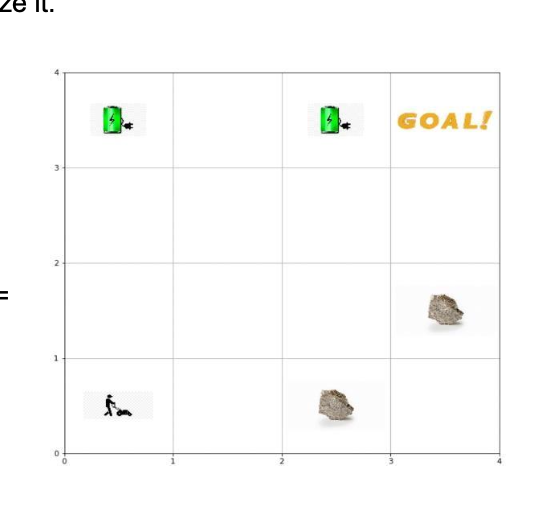

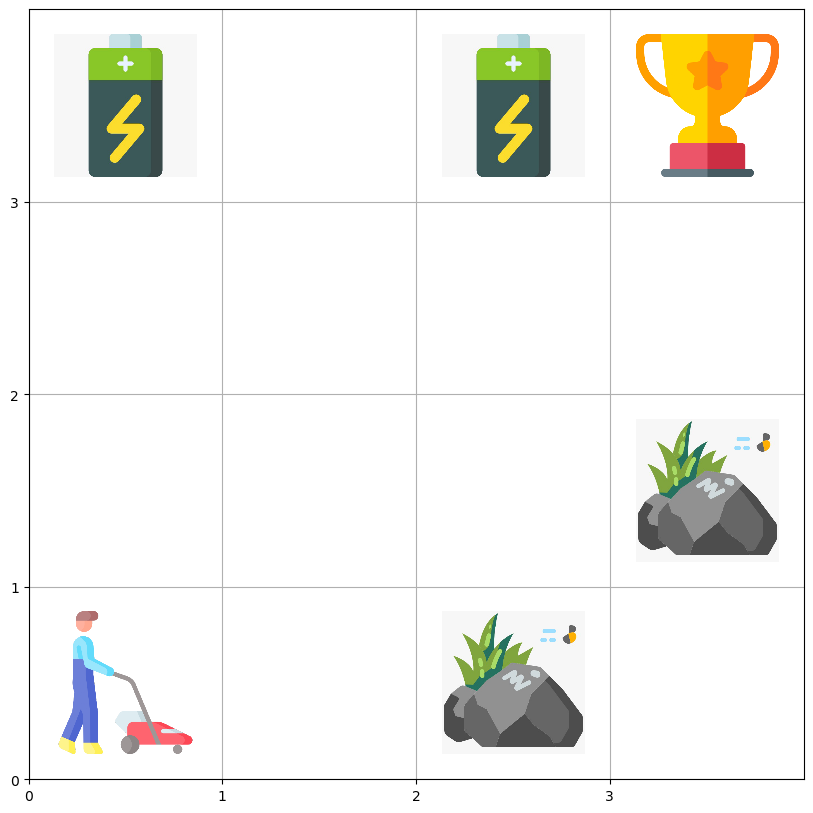

In [3]:
class LawnmowerGridWorldEnvironment(gym.Env):

    def __init__(self, max_timesteps = 10):
        self.environment_width = 4
        self.environment_height = 4
        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height) #16
        self.state = np.zeros((4,4))
        self.action_space = spaces.Discrete(4) #up,down,right,left
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3,3])
        self.max_timesteps = max_timesteps
        self.timestep = 0
        self.battery_pos = np.asarray([[3, 0], [3, 2]]) #rewards -> +5, +6
        self.rock_pos = np.asarray([[0, 2], [1, 3]]) #rewards -> -5, -6
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.reward = 0

    def reset(self):
        self.timestep = 0
        self.reward = 0
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3,3])
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8

        observation = self.state.flatten() #cur pos of agent

        return self.agent_pos, observation

    def step(self, action):
        if action == 0:
            self.agent_pos[0] += 1  # This action causes the agent to go up.
        if action == 1:
            self.agent_pos[0] -= 1  # This action causes the agent to go down.
        if action == 2:
            self.agent_pos[1] -= 1  # This action causes the agent to go left.
        if action == 3:
            self.agent_pos[1] += 1  # This action causes the agent to go right.

        truncated = False if np.all((self.agent_pos[0] >= 0 ) and (self.agent_pos[0] <= 3) and (self.agent_pos[1] >= 0 ) and (self.agent_pos[1] <= 3)) else True
        
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
    
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        observation = self.state.flatten()

        reward = 0
        if(truncated == False):
            if np.array_equal(self.agent_pos, self.battery_pos[0]):
                reward = 5
            elif np.array_equal(self.agent_pos, self.battery_pos[1]):
                reward = 6
            elif np.array_equal(self.agent_pos, self.rock_pos[0]):
                reward = -5
            elif np.array_equal(self.agent_pos, self.rock_pos[1]) :
                reward = -6
            elif np.array_equal(self.agent_pos, self.goal_pos):
                reward = 15
        
        self.timestep += 1

        # Condition to check for termination (episode is over)
        terminated = True if (np.array_equal(self.agent_pos, self.goal_pos) or self.timestep >= self.max_timesteps - 1) else False

        return self.agent_pos, observation, reward, terminated

    def render(self, plot=False):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 4)

        def plot_image(plot_pos):
            # Initially setting every object to not be plotted.
            plot_agent, plot_battery, plot_rock, plot_goal = False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if any(np.array_equal(self.battery_pos[i], plot_pos) for i in range(len(self.battery_pos))):
                plot_battery = True
            if any(np.array_equal(self.rock_pos[i], plot_pos) for i in range(len(self.rock_pos))):
                plot_rock = True
            if np.array_equal(self.goal_pos, plot_pos):
                plot_goal = True

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_battery, plot_rock, plot_goal]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./images/lawnmower.png'), zoom=0.2),
                                       np.add(np.flip(plot_pos), [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            # Plot for Battery
            elif plot_battery and \
                    all(not item for item in
                        [plot_agent, plot_rock, plot_goal]):
                battery = AnnotationBbox(OffsetImage(plt.imread('./images/battery.jpeg'), zoom=0.2), np.add(np.flip(plot_pos), [0.5, 0.5]), frameon=False)
                ax.add_artist(battery)

            # Plot for Rock
            elif plot_rock and \
                    all(not item for item in
                        [plot_agent, plot_battery, plot_goal]):
                rock = AnnotationBbox(OffsetImage(plt.imread('./images/rock.jpeg'), zoom=0.2),
                                        np.add(np.flip(plot_pos), [0.5, 0.5]), frameon=False)
                ax.add_artist(rock)

            # Plot for Goal
            elif plot_goal and \
                    all(not item for item in
                        [plot_battery, plot_rock, plot_agent]):
                goal = AnnotationBbox(OffsetImage(plt.imread('./images/award.png'), zoom=0.2),
                                     np.add(np.flip(plot_pos), [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)

            elif plot_agent and \
                    any(item for item in
                        [plot_rock, plot_battery]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./images/lawnmower.png'), zoom=0.2),
                                       np.add(np.flip(plot_pos), [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)


        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])
            
        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3])
        plt.yticks([0, 1, 2, 3])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image


lawnmover_world = LawnmowerGridWorldEnvironment()
lawnmover_world.reset()
lawnmover_world.render(plot=True)

In [4]:
# Definition an agent that takes action randomly
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def step(self, obs):
        return np.random.choice(self.action_space.n)

Agent Pos:  [0 0] Action: 1 , Reward: 0 , Done: False


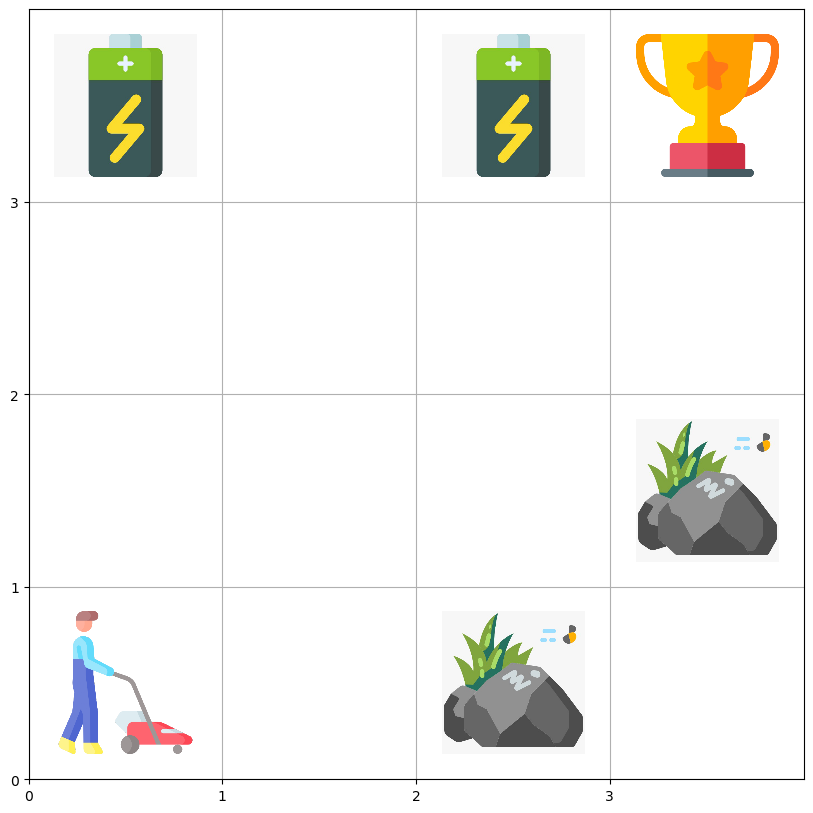

Agent Pos:  [1 0] Action: 0 , Reward: 0 , Done: False


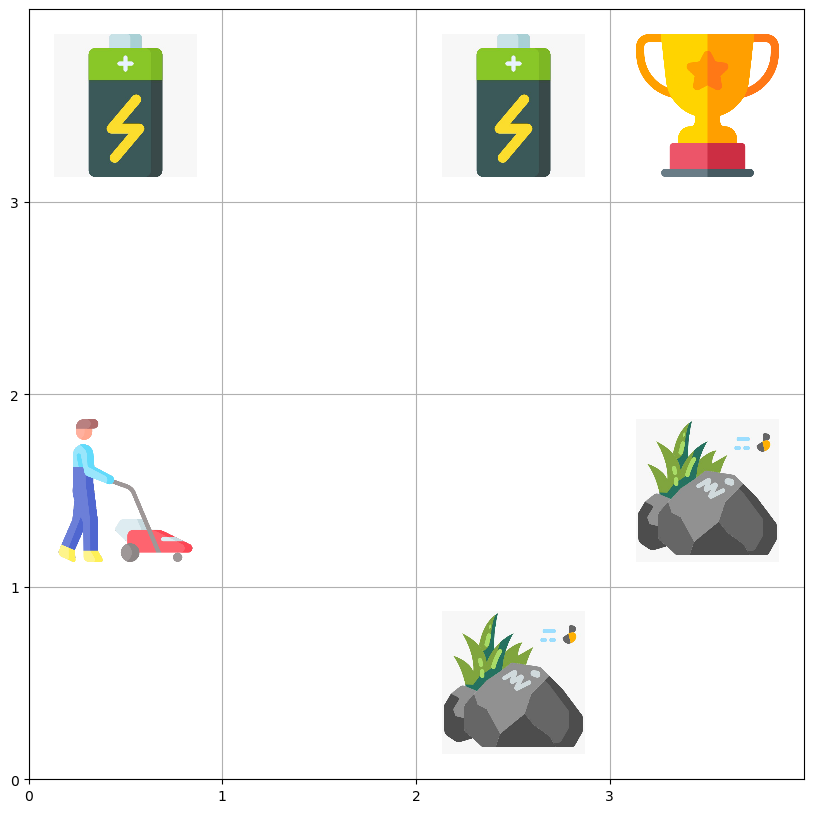

Agent Pos:  [1 0] Action: 2 , Reward: 0 , Done: False


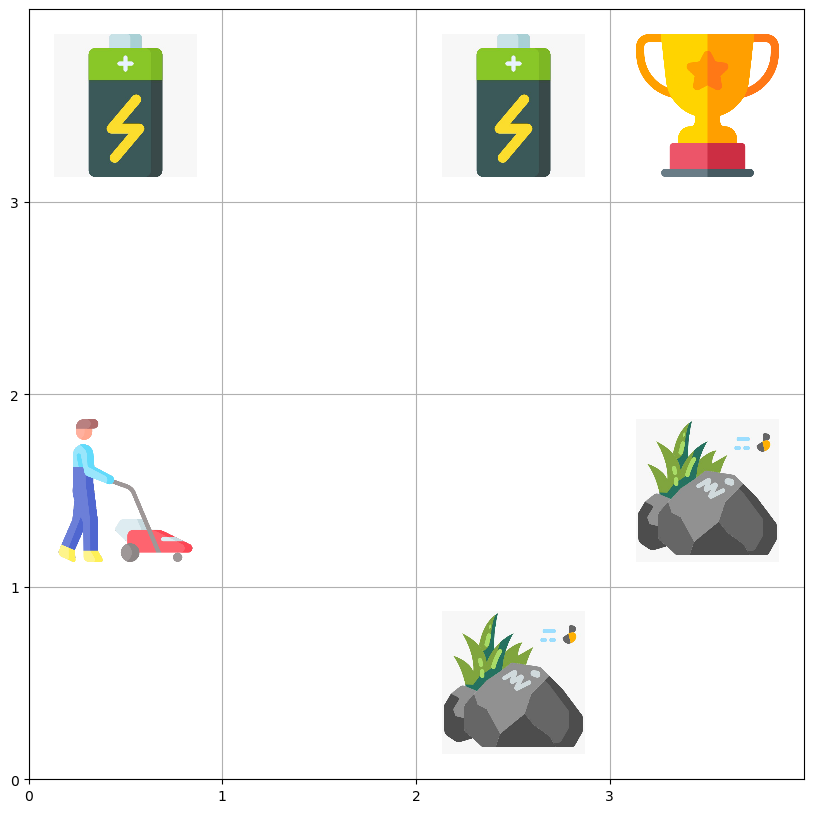

Agent Pos:  [1 0] Action: 2 , Reward: 0 , Done: False


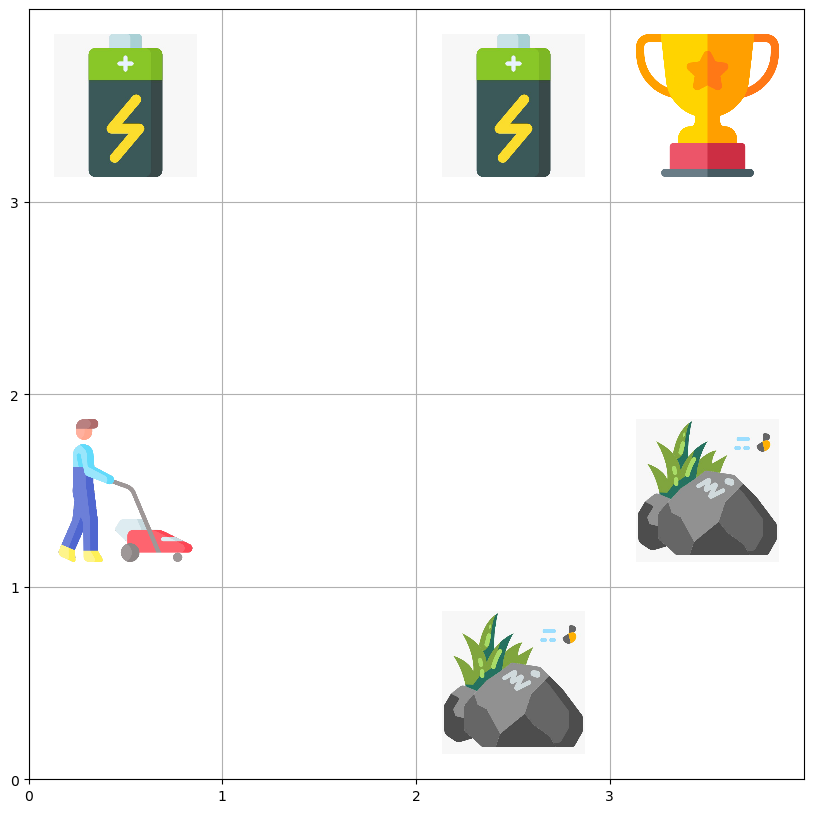

Agent Pos:  [1 1] Action: 3 , Reward: 0 , Done: False


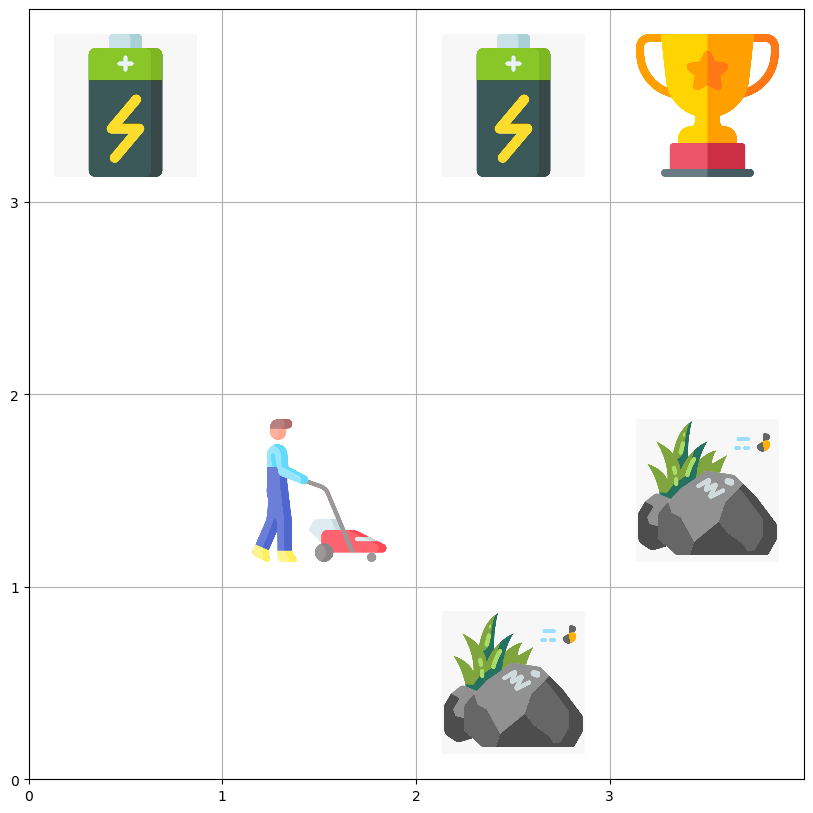

Agent Pos:  [0 1] Action: 1 , Reward: 0 , Done: False


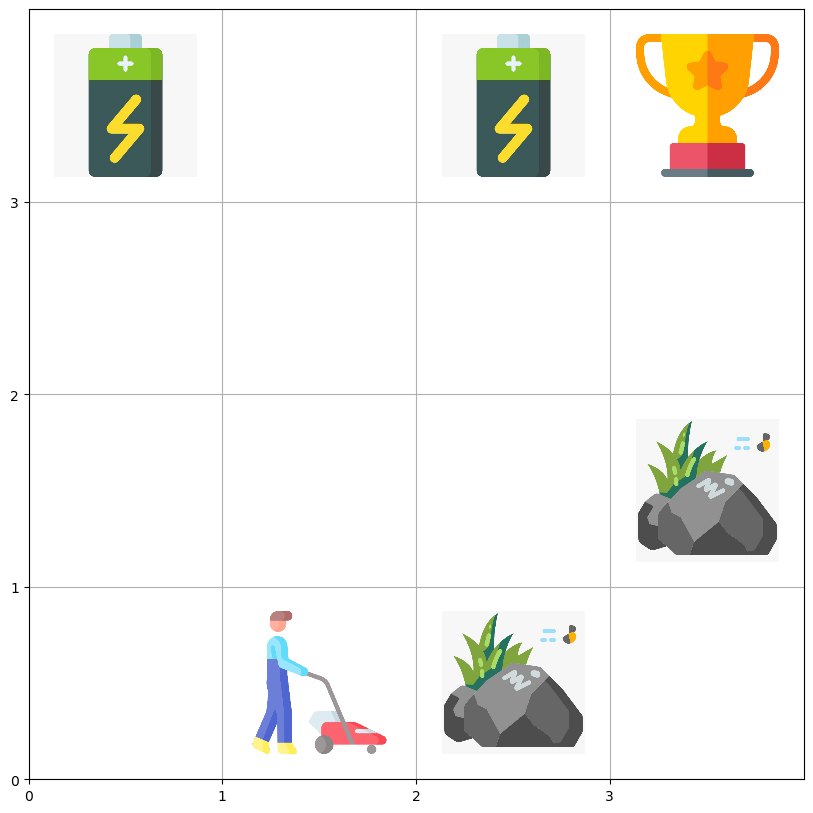

Agent Pos:  [0 0] Action: 2 , Reward: 0 , Done: False


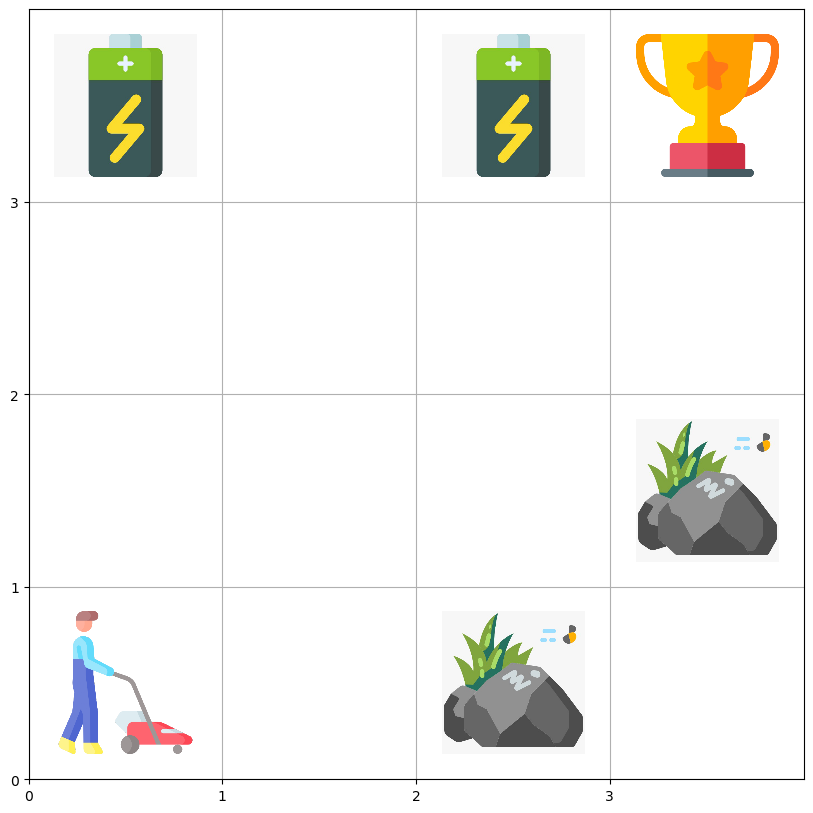

Agent Pos:  [0 0] Action: 1 , Reward: 0 , Done: False


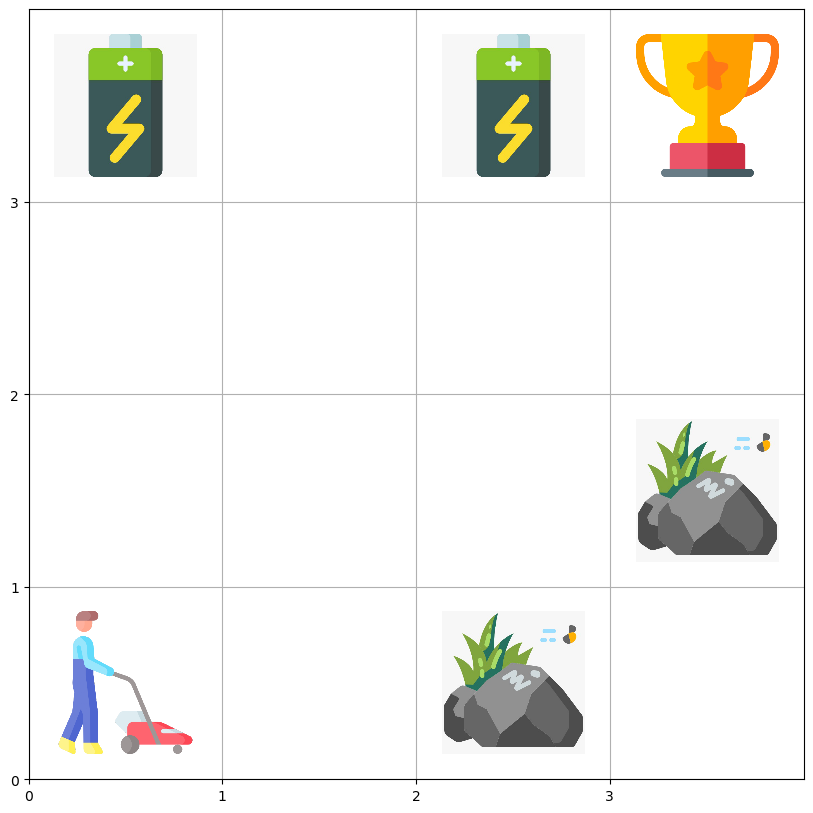

Agent Pos:  [0 0] Action: 2 , Reward: 0 , Done: True


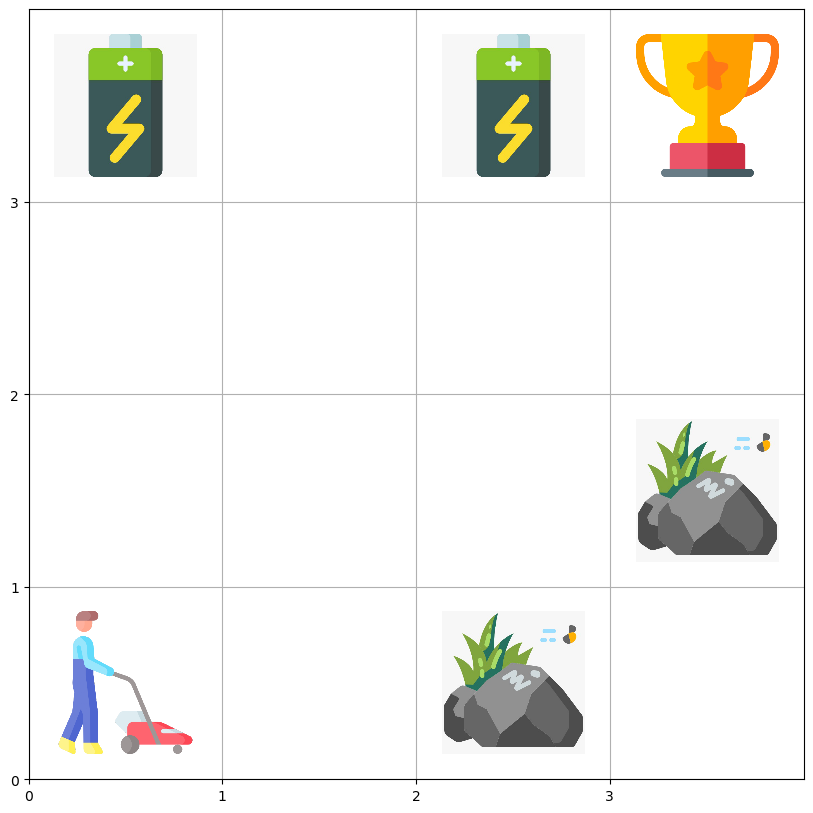

In [5]:
env = LawnmowerGridWorldEnvironment()
agent = RandomAgent(env)

pos, obs = env.reset()
terminated = False
total_reward = 0

while not terminated:
    action = agent.step(obs)
    pos, obs, reward, terminated = env.step(action)
    total_reward += reward
    print('Agent Pos: ',pos,'Action:', action, ', Reward:', total_reward, ', Done:', terminated)
    env.render()

## Part 2 - Implement SARSA

In [6]:
def get_state_index_in_flatten_array(curr_state, state):
    row_index = curr_state[0]
    col_index = curr_state[1]
    max_cols = state.shape[1]
    return row_index * max_cols + col_index

In [7]:
def select_action_from_Q(Q, state, epsilon):
    action = 0
    if epsilon > np.random.uniform(0, 1):
        total_actions = Q.shape[1]
        action = np.random.randint(total_actions)
    else:
        action = np.argmax(Q[state])
    
    return action

In [8]:
def SARSA_Agent(env, episodes, epsilon, learning_rate, discount_factor, epsilon_decay):
    total_episodes = episodes
    total_actions = env.action_space.n
    total_states = env.observation_space.n

    # Initializing our Q matrix
    Q = np.zeros((total_states, total_actions))

    initial_q_table = copy.deepcopy(Q)
    reward_values = []
    epsilon_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_action_from_Q(Q, curr_agent_state, epsilon)

        if epsilon > 0.01:
            epsilon = epsilon * epsilon_decay
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_action_from_Q(Q, next_agent_state, epsilon)

            Q[curr_agent_state][curr_action] = Q[curr_agent_state][curr_action] + learning_rate * (reward + discount_factor * Q[next_agent_state][next_action] - Q[curr_agent_state][curr_action])

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)
        epsilon_values.append(epsilon)

    return initial_q_table, Q, reward_values, epsilon_values

In [9]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, sarsa_trained_q_table, sarsa_reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

### Evaluation Metrics

In [10]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes, trained_q_table):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
sarsa_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
sarsa_greedy_reward_values = Trained_SARSA_Agent(env, episodes=sarsa_greedy_episodes, trained_q_table=sarsa_trained_q_table)

In [11]:
# Print evalution metrics

def print_evaluation_metrics(
        initial_q_table, 
        trained_q_table, 
        episodes, reward_values, 
        epsilon_values, 
        sarsa_greedy_episodes, sarsa_greedy_reward_values,
        print_init_q_table = False,
        print_trained_q_table = False,
        plot_rewards_per_episode = False, 
        plot_epsilon_decay = False,
        plot_greedy_action_reward = False
):
    episodes_list = [episode for episode in range(episodes)]
    sarsa_greedy_episodes_list = [greedy_episode for greedy_episode in range(sarsa_greedy_episodes)]

    if(print_init_q_table):
        print("Initial Q-table - \n")
        print(f"{initial_q_table} \n")
    
    if(print_trained_q_table):
        print("Trained Q-table - \n")
        print(f"{trained_q_table}")
    
    if(plot_rewards_per_episode):
        plt.figure()    
        plt.plot(episodes_list, reward_values)
        plt.title("Rewards per episode")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')

    if(plot_epsilon_decay):    
        plt.figure()
        plt.plot(episodes_list, epsilon_values)
        plt.title("Epsilon decay graph")
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon Values')

    if(plot_greedy_action_reward):
        plt.figure()    
        plt.plot(sarsa_greedy_episodes_list, sarsa_greedy_reward_values)
        plt.title("Rewards per episode (Greedy)")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        


Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 1.05675338e+01  4.06790370e+00  3.66431175e+00  5.76803687e-01]
 [ 6.12961024e-02  6.80904031e-02  3.29011388e+00 -3.46863479e+00]
 [-4.24769715e-01 -5.48158369e-02 -7.89907081e-02 -1.38720000e-01]
 [-1.14000000e+00  0.00000000e+00 -1.73562800e+00 -1.09116800e-01]
 [ 1.32150614e+01  1.82979342e+00  6.16238144e+00  6.27292819e-01]
 [ 3.08653166e+00 -1.40869178e-01  1.27633400e+00 -2.53622667e-02]
 [ 3.50963668e-01 -2.64330632e+00  9.08336131e-03 -6.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.65199906e+01  6.49807691e+00  7.23576770e+00  4.26602101e+00]
 [ 2.35334847e+00  3.99889335e-01  1.05796652e+01  1.71613121e+00]
 [ 1.47163623e+01 -2.05832542e-01  4.40206494e-

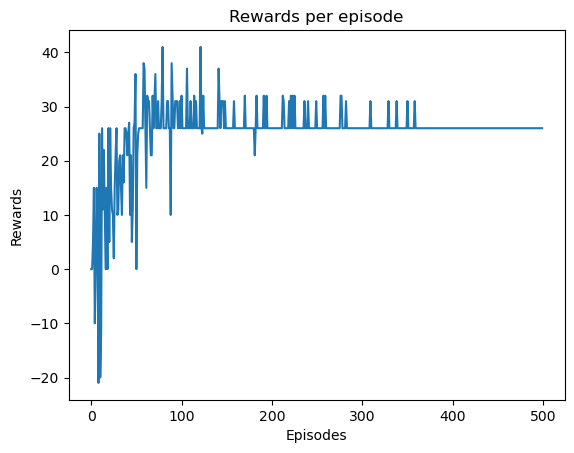

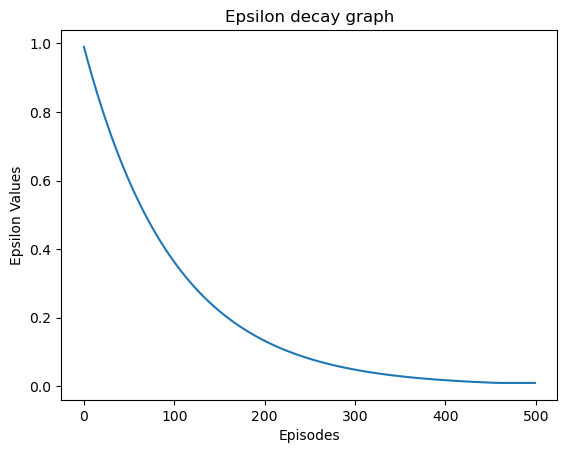

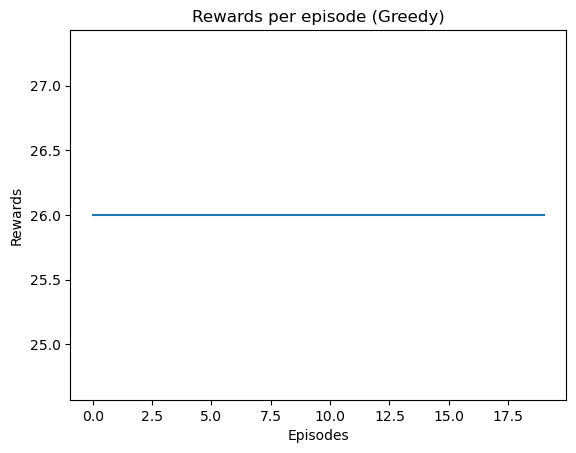

In [12]:
print_evaluation_metrics(
    initial_q_table, 
    sarsa_trained_q_table, 
    episodes, sarsa_reward_values, 
    epsilon_values, 
    sarsa_greedy_episodes, sarsa_greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

### Hyperparamters Tuning (Number of Episodes)

#### Setup 1 
#### no of episodes-100

In [13]:
max_timesteps = 20
episodes = 100
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [14]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes, trained_q_table):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes, trained_q_table=trained_q_table)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 3.55232958  0.81591637  1.26148679 -0.47317417]
 [ 0.18374283 -0.86408509 -0.15301712 -4.80540959]
 [-0.58261479 -0.249039   -0.71007146 -0.50814432]
 [-3.44873431 -0.25283257 -1.75381403 -0.36551741]
 [ 5.71606723  0.24769894  1.66396687  0.29221523]
 [ 1.47161781 -0.46908046  0.67613557 -0.4858233 ]
 [ 0.7774033  -3.55340726  0.02279811 -2.80000849]
 [ 0.20904    -0.16717597 -0.02640496  0.0474816 ]
 [ 9.69699807  1.62379087  3.37966129  0.95362761]
 [ 4.42642269  0.25444147  3.41348859  2.683248  ]
 [11.44161553 -0.2630722   0.77392579  0.70536   ]
 [ 6.14265    -0.6         0.94178252  0.        ]
 [ 3.84703391  3.68104374  1.87207711  9.47521909]
 [ 4.00316622  1.60285125  7.9048138  15.92629647]
 [ 

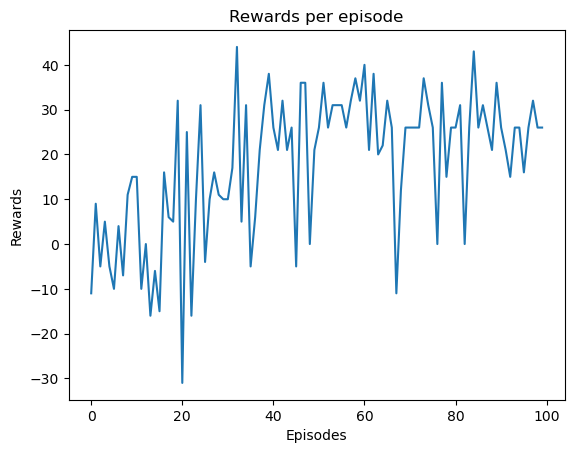

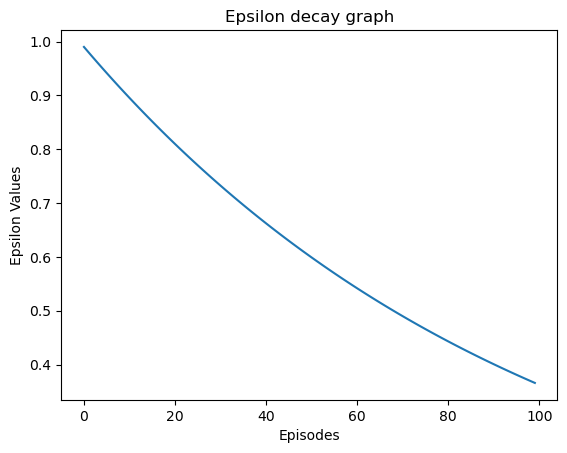

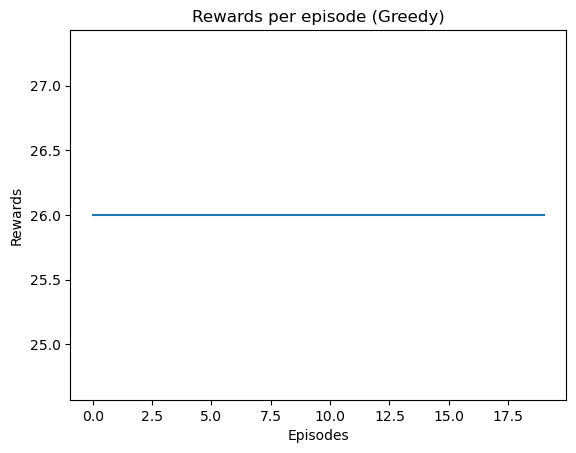

In [15]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 2

no of epsiodes - 1000

In [16]:
max_timesteps = 20
episodes = 1000
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [17]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 1.04632254e+01  2.69495863e+00  4.65725471e+00  1.84333836e+00]
 [ 4.14213020e+00 -1.11174325e-01  2.51101878e-01 -4.48601952e+00]
 [-3.15717967e-01 -1.31506429e-01  1.37680978e-01 -1.33784832e-01]
 [-2.47047538e+00 -1.94816384e-01 -1.75072765e+00 -1.98464338e-01]
 [ 1.30113051e+01  4.83469756e+00  4.29714092e+00  3.26367590e+00]
 [ 7.85370536e+00  9.91142339e-02  8.56432211e-01  1.27854227e+00]
 [ 7.31283729e+00 -3.36769389e+00  1.80593691e-02 -3.87194531e+00]
 [-1.65973309e-01 -1.30146467e-01  2.68833505e-01  7.84142718e-03]
 [ 1.62548140e+01  5.60180632e+00  8.94879287e+00  4.98652202e+00]
 [ 3.19595853e+00  1.45151941e+00  3.38983959e+00  1.29135988e+01]
 [ 1.77441404e+01  1.56400153e+00  2.05948922e+

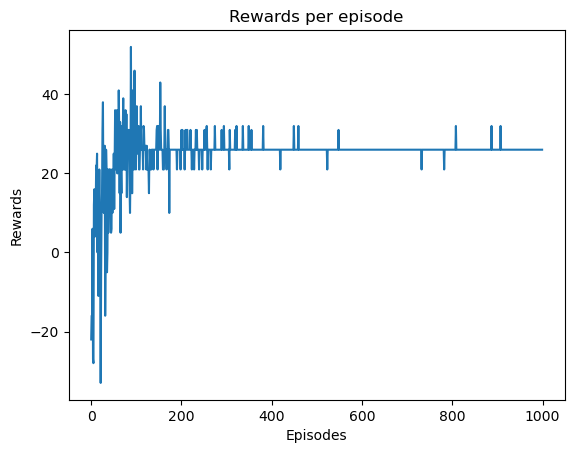

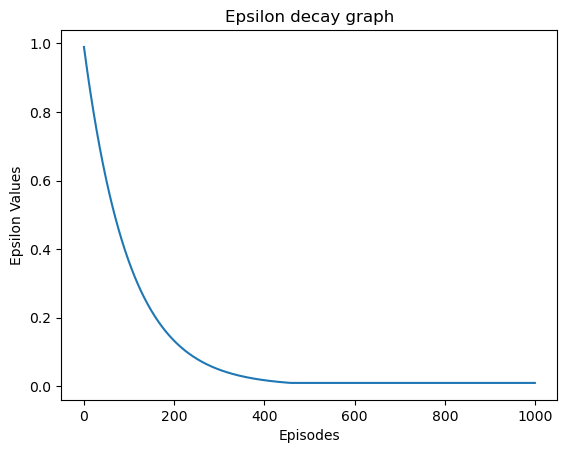

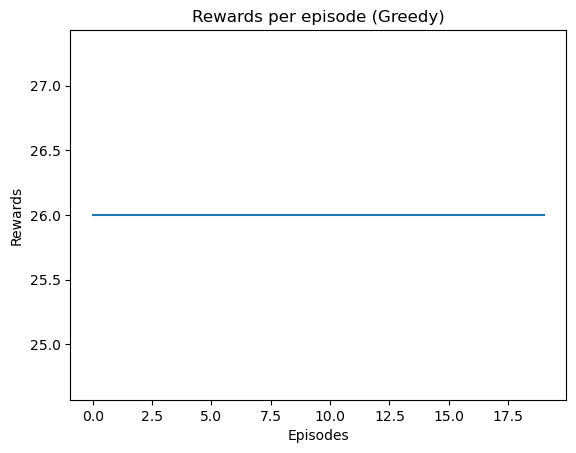

In [18]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 3
no of episodes-1500

In [19]:
max_timesteps = 20
episodes = 1500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [20]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 1.04078824e+01  4.84226800e+00  5.49271128e+00  1.12654980e+00]
 [ 3.52146139e+00 -5.86334316e-01  2.68647897e-01 -4.08660899e+00]
 [-2.88100443e-02 -5.31349748e-02 -4.67410745e-02 -1.73329251e-01]
 [-2.06340000e+00 -2.75048408e-01 -2.35470166e+00 -2.69773166e-01]
 [ 1.30776320e+01  3.87112130e+00  6.30256740e+00  3.34395686e+00]
 [ 3.14064140e-01 -3.00496207e-01  8.54567107e+00  4.49267032e-01]
 [ 2.11890670e+00 -2.62406889e+00  5.88739184e-02 -2.45205364e+00]
 [ 1.37425055e+00 -3.84000000e-03  1.99363828e-01  5.83183124e-02]
 [ 1.64525419e+01  6.07154002e+00  1.05229159e+01  4.93868549e+00]
 [ 3.10369010e+00  1.44761622e-01  3.94224951e+00  1.17916765e+01]
 [ 1.75894158e+01 -1.71368083e-01  1.95065590e+

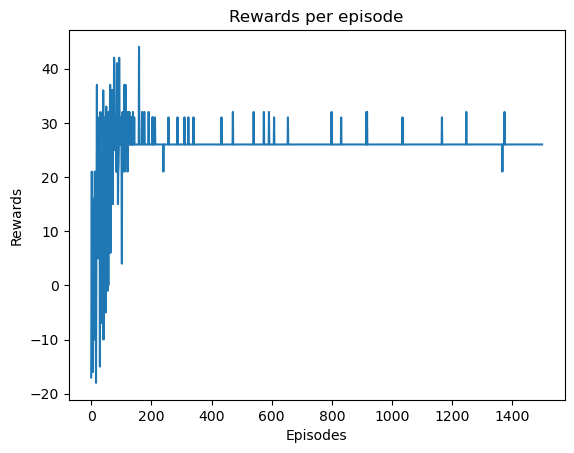

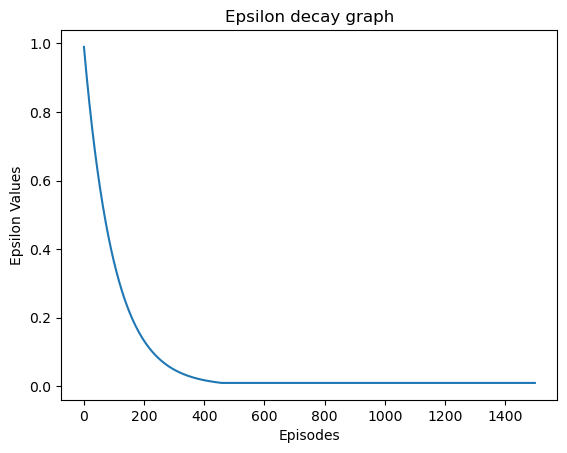

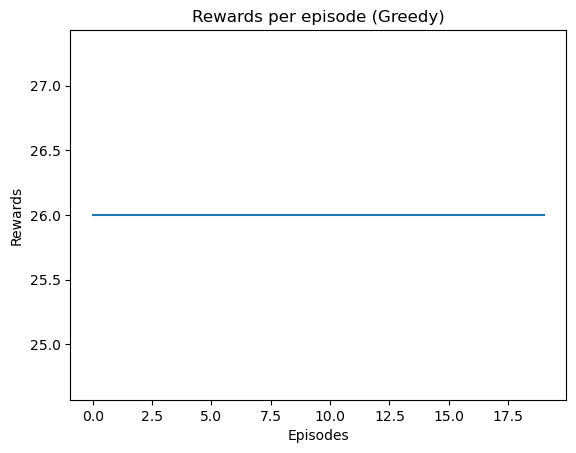

In [21]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

### Hyperparamters Tuning (Epsilon Decay)

#### Setup 1 

epsilon_decay=0.84

In [22]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.84

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [23]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 8.77938462e+00  9.60496156e-03  6.98860908e-01  6.02155009e-04]
 [ 5.85602496e-02  0.00000000e+00  0.00000000e+00 -5.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.09678517e+01  3.63298770e-02  1.65405220e+00  4.02161147e-02]
 [ 1.03493452e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.80000000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.36230392e+01  8.95749601e-01  2.32482703e+00  8.31074211e-02]
 [ 8.14440362e+00  1.67653908e-03  0.00000000e+00  0.00000000e+00]
 [ 1.14000000e+00  0.00000000e+00  0.00000000e+

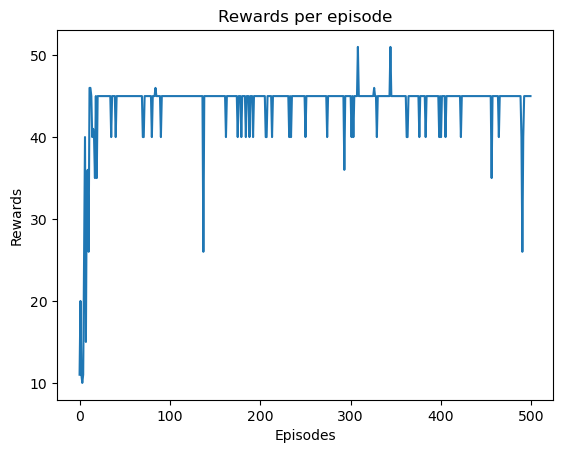

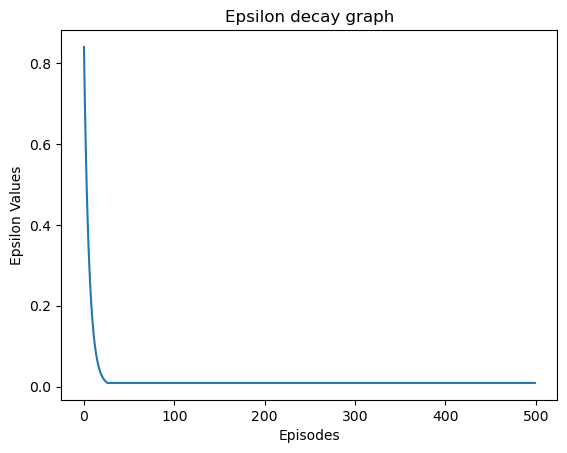

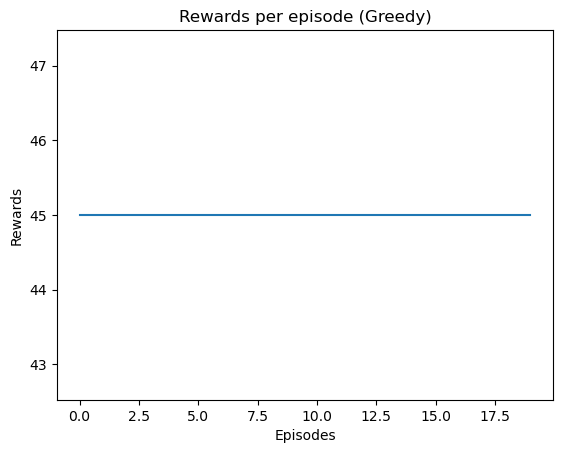

In [24]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 2

epsilon_decay=0.94

In [25]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.94

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [26]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 8.71866701e+00  4.61792196e-02  2.86364996e+00  1.12195291e-01]
 [ 0.00000000e+00  0.00000000e+00  1.67963835e+00 -9.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.00000000e-01  0.00000000e+00 -5.00000000e-01  0.00000000e+00]
 [ 1.08516371e+01  6.68442448e-01  2.98832142e+00  9.66029024e-02]
 [ 0.00000000e+00  0.00000000e+00  1.60876522e+00 -4.80000000e-02]
 [ 4.18641883e-01 -5.00000000e-01  0.00000000e+00 -1.14000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.36960368e+01  5.40391498e+00  8.54073082e+00  3.16417261e+00]
 [ 7.03394386e-01  0.00000000e+00  1.47878632e-02  7.14711641e+00]
 [ 1.36710287e+01  3.84000000e-03  0.00000000e+

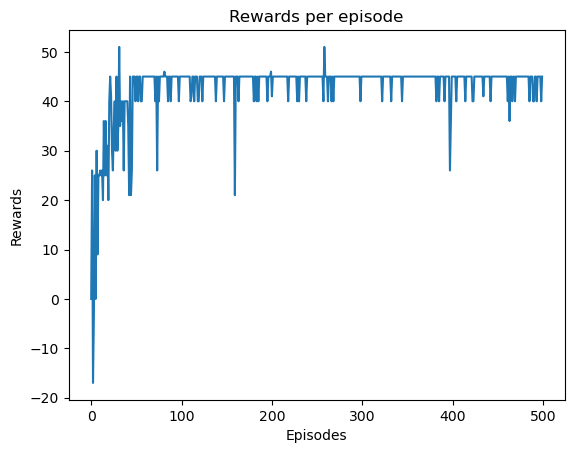

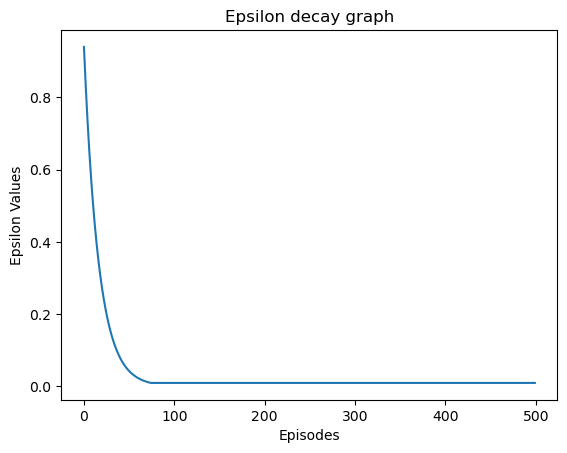

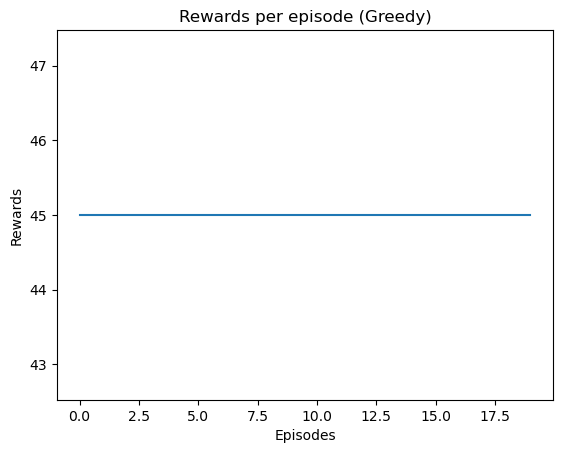

In [27]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 3

In [28]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [29]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 1.05066644e+01  4.08093159e+00  3.17047857e+00  1.08480014e+00]
 [ 4.93933213e-01 -2.78262954e-01  4.19333746e+00 -3.78440767e+00]
 [-1.79707334e-01 -4.76591083e-02 -2.74873888e-01 -2.50925648e-01]
 [-2.43906883e+00 -1.32229093e-01 -9.50000000e-01 -1.60109261e-01]
 [ 1.31913902e+01  3.60115110e+00  2.53253319e+00  1.79228964e+00]
 [ 5.26709038e+00 -1.78133374e-01  9.66414081e-01 -6.30275833e-01]
 [ 2.80574172e+00 -3.46288992e+00  2.10833560e-02 -2.47077179e+00]
 [ 8.31243720e-01 -6.65600000e-03 -1.17184858e-01 -1.15580102e-02]
 [ 1.65106744e+01  5.32468512e+00  7.70356258e+00  5.38401790e+00]
 [ 1.24357478e+01  7.10981860e-01  2.62096061e+00  2.76667245e+00]
 [ 1.35299716e+01 -1.40632295e-02  3.17412770e+

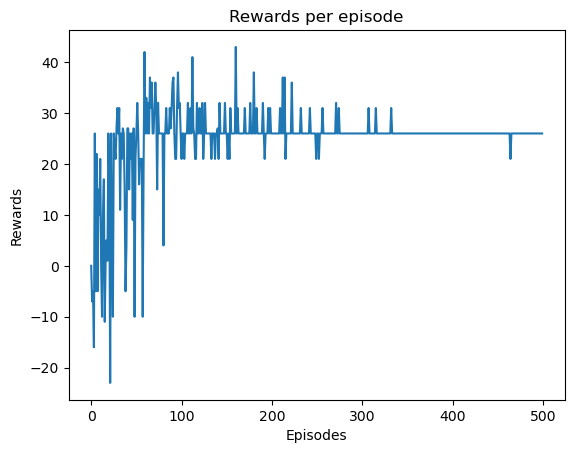

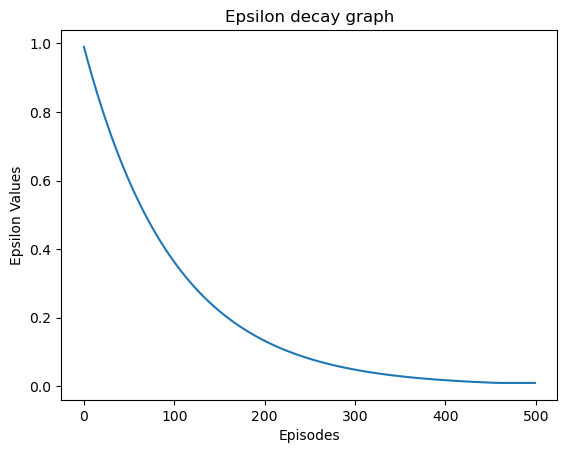

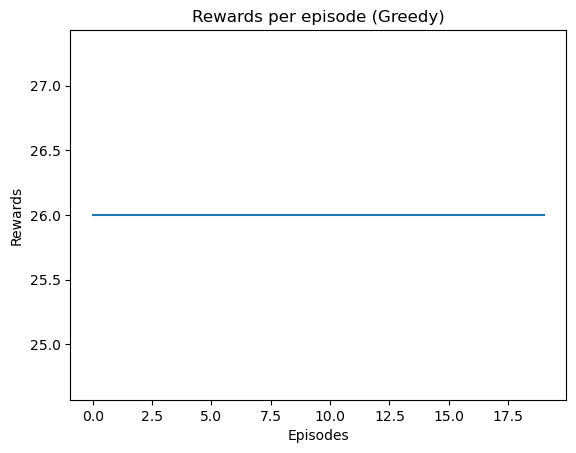

In [30]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

### Hyperparamters Tuning (Discount Factor)

#### setup1
discount_factor - 0.3

In [31]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.3
epsilon_decay = 0.9

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [32]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 5.22810924e-01  0.00000000e+00  3.04923818e-02  2.38683861e-06]
 [ 2.21953255e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.75989189e+00  1.35410480e-02  5.31070051e-02  0.00000000e+00]
 [ 3.72745425e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01  0.00000000e+00 -6.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.91724682e+00  0.00000000e+00  6.53817165e-01  5.83396160e-02]
 [ 1.34798176e+00  0.00000000e+00  1.21950000e-03  1.80000000e-02]
 [ 1.35085155e+00  0.00000000e+00  0.00000000e+

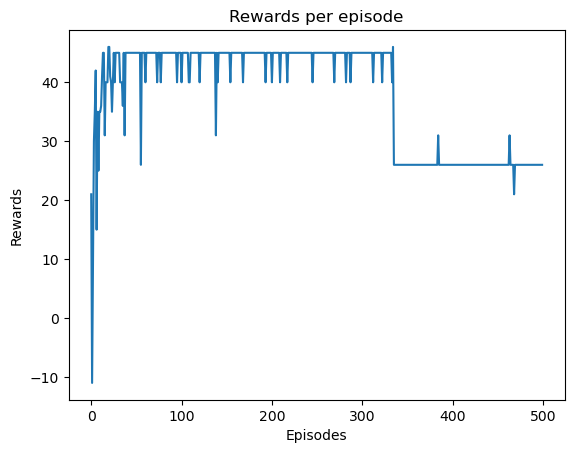

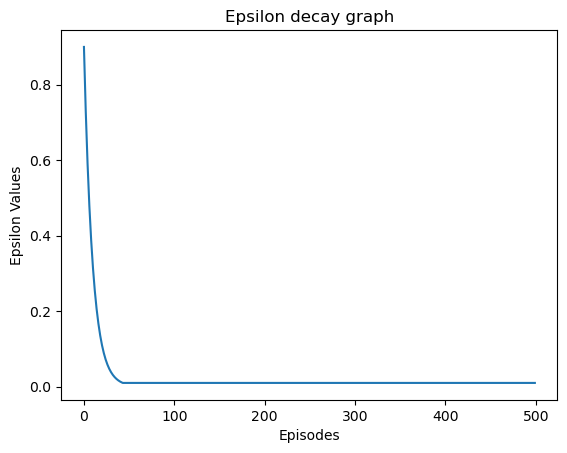

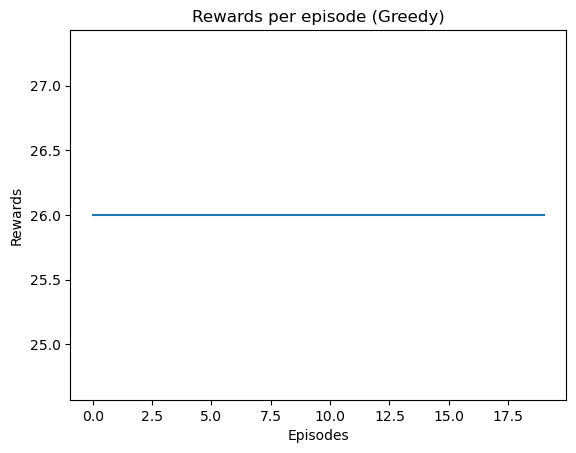

In [33]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### setup 2
#### discount factor = 0.5

In [34]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.5
epsilon_decay = 0.9

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [35]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table

    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 1.65713792e+00  1.01196738e-01  3.02991203e-01  1.79085938e-05]
 [ 2.14489769e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.31534081e+00  7.52846564e-03  3.97752752e-01  1.74719823e-03]
 [ 0.00000000e+00  0.00000000e+00  1.01447093e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.56428336e+00  1.35016489e+00  2.52860699e+00  8.15922919e-01]
 [ 0.00000000e+00  0.00000000e+00  2.68378620e+00  0.00000000e+00]
 [ 6.00000000e-01 -3.00000000e-02  0.00000000e+

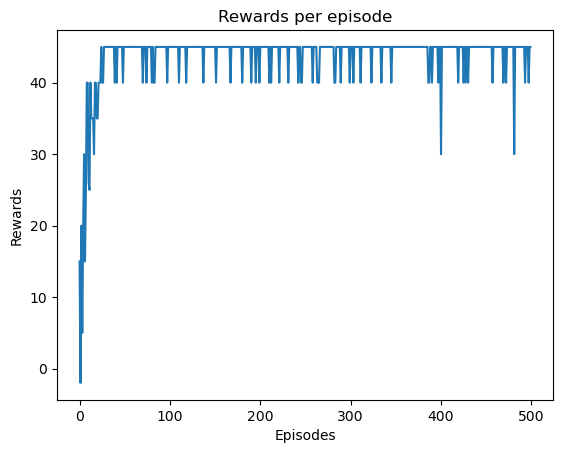

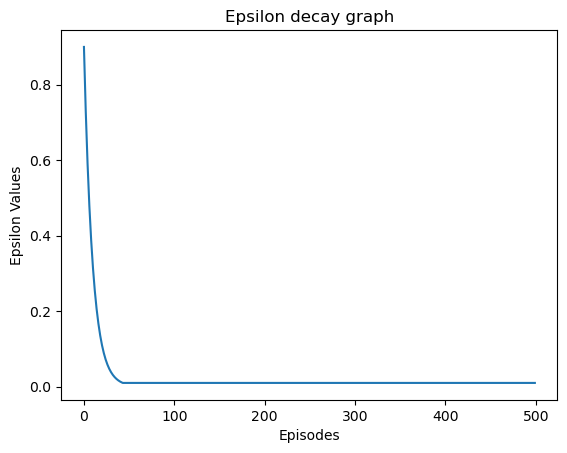

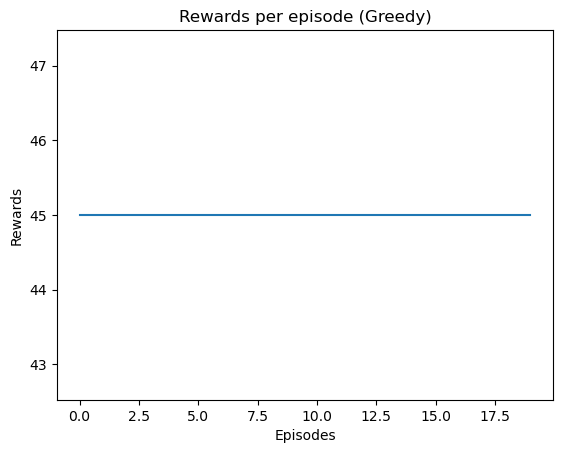

In [36]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### setup 3
#### discount factor - 0.9

In [37]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.9
epsilon_decay = 0.9

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_q_table, trained_q_table, reward_values, epsilon_values = SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay)

In [38]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q = trained_q_table
    
    reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        
        while not terminated:

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
            next_action = select_only_greedy_action_from_Q(Q, next_agent_state)

            curr_agent_state = next_agent_state
            curr_action = next_action
            total_reward_per_episode += reward

        reward_values.append(total_reward_per_episode)

    return reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
greedy_reward_values = Trained_SARSA_Agent(env, episodes=greedy_episodes)

Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 2.00585588e+01  2.31432015e-02  1.82199388e+00  9.11408762e-04]
 [ 5.57869493e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23943603e+01  1.29087959e-01  2.07355341e+00  2.49685941e-03]
 [ 1.26203757e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.61500000e-02 -5.00000000e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.52568555e+01  1.29180060e+01  1.94914624e+01  3.71881070e+00]
 [ 9.35111502e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.51800000e+00  0.00000000e+00  0.00000000e+

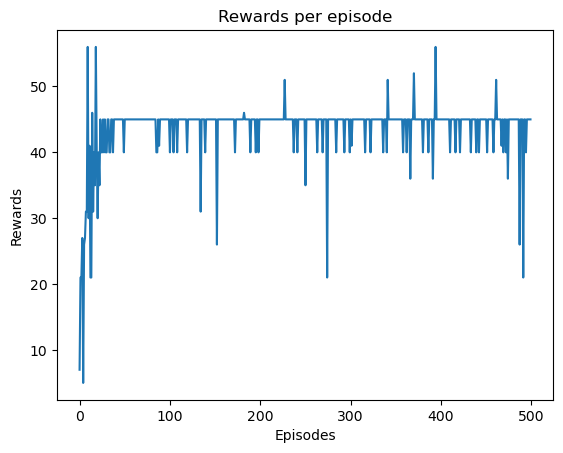

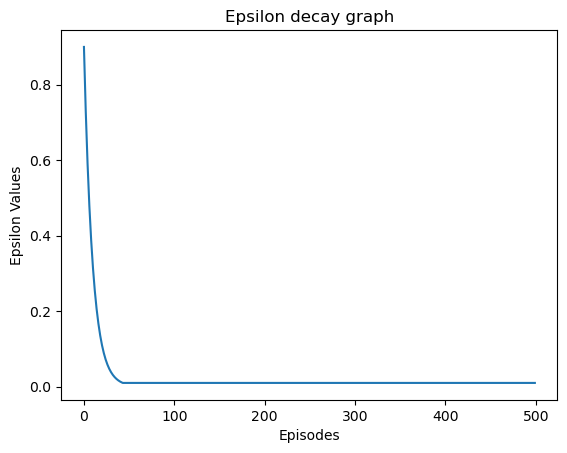

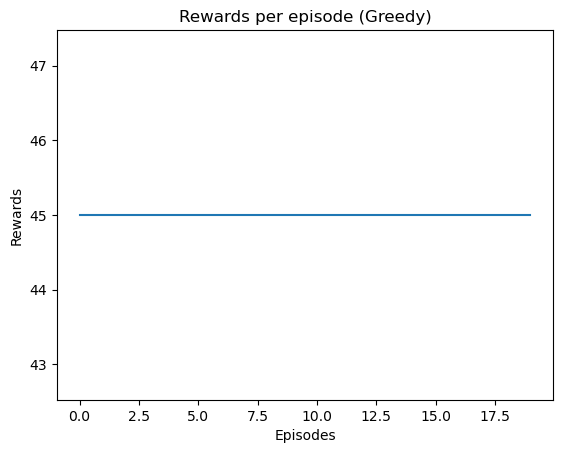

In [39]:
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    greedy_episodes, greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

## Part 3 - Implement Double Q-Learning

In [40]:
def get_state_index_in_flatten_array(curr_state, state):
    row_index = curr_state[0]
    col_index = curr_state[1]
    max_cols = state.shape[1]
    return row_index * max_cols + col_index

In [41]:
def select_action_from_Q(Q, state, epsilon):
    action = 0
    if epsilon > np.random.uniform(0, 1):
        total_actions = Q.shape[1]
        action = np.random.randint(total_actions)
    else:
        action = np.argmax(Q[state])
    
    return action

In [42]:
def Double_Q_Learning_Agent(env, episodes, epsilon, learning_rate, discount_factor, epsilon_decay):
    total_episodes = episodes
    total_actions = env.action_space.n
    total_states = env.observation_space.n

    # Initializing our Q matrices
    Q1 = np.zeros((total_states, total_actions))
    Q2 = np.zeros((total_states, total_actions))

    initial_q1_table = copy.deepcopy(Q1)
    initial_q2_table = copy.deepcopy(Q2)
    
    dq_reward_values = []
    epsilon_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)

        if epsilon > 0.01:
            epsilon = epsilon * epsilon_decay
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_action_from_Q(Q_combined, curr_agent_state, epsilon)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            if(np.random.rand() < 0.5):
                Q1[curr_agent_state][curr_action] = Q1[curr_agent_state][curr_action] + learning_rate * (reward + discount_factor * Q2[next_agent_state][np.argmax(Q1[next_agent_state])] - Q1[curr_agent_state][curr_action])
            else:
                Q2[curr_agent_state][curr_action] = Q2[curr_agent_state][curr_action] + learning_rate * (reward + discount_factor * Q1[next_agent_state][np.argmax(Q2[next_agent_state])] - Q2[curr_agent_state][curr_action])

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_reward_values.append(total_reward_per_episode)
        epsilon_values.append(epsilon)

    return initial_q1_table, initial_q2_table, Q1, Q2, dq_reward_values, epsilon_values

In [43]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, dq_reward_values, epsilon_values = Double_Q_Learning_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

### Evaluation Metrics

In [44]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

In [45]:
# Print evalution metrics
def print_evaluation_metrics(
        initial_q1_table, 
        trained_q1_table, 
        initial_q2_table, 
        trained_q2_table, 
        episodes, dq_reward_values, 
        epsilon_values, 
        dq_greedy_episodes, dq_greedy_reward_values,
        print_init_q1_table = False,
        print_init_q2_table = False,
        print_trained_q1_table = False,
        print_trained_q2_table = False,
        plot_rewards_per_episode = False, 
        plot_epsilon_decay = False,
        plot_greedy_action_reward = False 
):
    episodes_list = [episode for episode in range(episodes)]
    greedy_episodes_list = [greedy_episode for greedy_episode in range(dq_greedy_episodes)]

    if(print_init_q1_table):
        print("Initial Q1-table - \n")
        print(f"{initial_q1_table} \n")
    
    if(print_trained_q1_table):
        print("Trained Q1-table - \n")
        print(f"{trained_q1_table}")

    if(print_init_q2_table):
        print("Initial Q2-table - \n")
        print(f"{initial_q2_table} \n")
    
    if(print_trained_q2_table):
        print("Trained Q2-table - \n")
        print(f"{trained_q2_table}")
    
    if(plot_rewards_per_episode):
        plt.figure()    
        plt.plot(episodes_list, dq_reward_values)
        plt.title("Rewards per episode")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')

    if(plot_epsilon_decay):    
        plt.figure()
        plt.plot(episodes_list, epsilon_values)
        plt.title("Epsilon decay graph")
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon Values')

    if(plot_greedy_action_reward):    
        plt.figure()    
        plt.plot(greedy_episodes_list, dq_greedy_reward_values)
        plt.title("Rewards per episode (Greedy)")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')


Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 1.05724547e+01  3.76972131e+00  2.46726063e+00  9.49036757e-01]
 [ 5.50358036e-01  2.43265489e-01  3.66839059e+00 -2.84697037e+00]
 [ 0.00000000e+00  0.00000000e+00  1.30960291e-01  0.00000000e+00]
 [-1.56957120e+00  0.00000000e+00 -9.49634957e-01  0.00000000e+00]
 [ 1.32158438e+01  2.77171885e+00  5.49260372e+00  1.47566153e+00]
 [ 3.33409931e-01  2.16940555e-01  5.92261032e+00  4.37821056e-02]
 [ 1.65894624e-01 -5.00000000e-01  1.93440360e-02 -1.13136000e+00]
 [ 3.25200000e-01  0.00000000e+00  0.00000000e+00  6.99840000e-03]
 [ 1.65199745e+01  8.39932671e+00  9.97287533e+00  6.36388936e+00]
 [ 1.29143219e+01  6.67184517e-01  2.76253547e+00  3.08886542e+00]
 [ 8.34382020e+00  0.00000000e+00  6.04107896

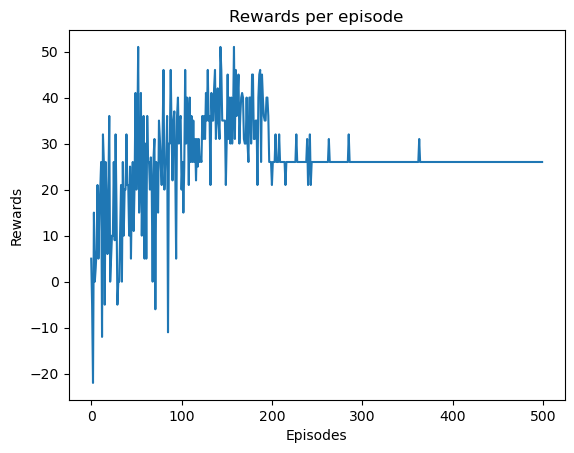

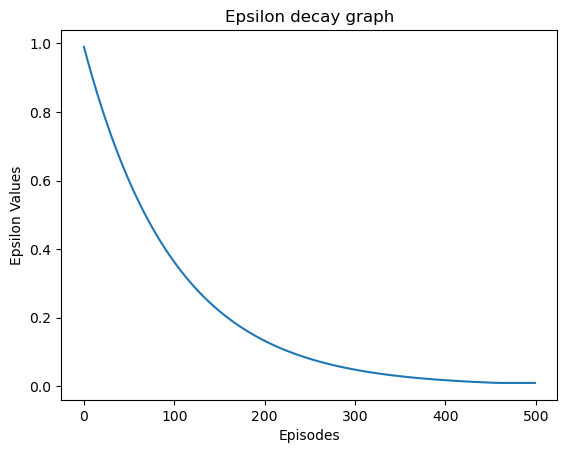

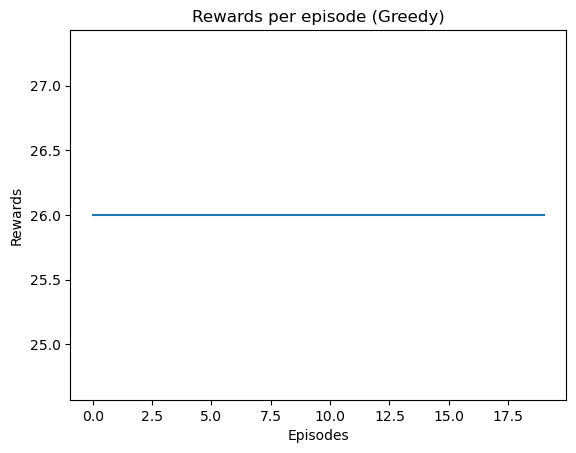

In [46]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, dq_reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

### Hyperparamters Tuning (Number of Episodes)

#### Setup 1 

In [47]:
max_timesteps = 20
episodes = 100
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, reward_values, epsilon_values = Double_Q_Learning_Agent(env,                episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

In [48]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 5.41044988e+00  1.25365756e+00  5.43806599e-01  2.06941022e-01]
 [ 1.83346686e-01  6.78102729e-02  1.43755549e+00 -3.56811683e+00]
 [ 1.97721600e-02  5.71019981e-03  0.00000000e+00  0.00000000e+00]
 [-1.13889101e+00  0.00000000e+00 -9.31447156e-01  0.00000000e+00]
 [ 9.13052068e+00  1.54757426e+00  2.00995080e+00  2.26513212e-01]
 [ 6.02364159e-01  9.73657227e-02  2.18557048e+00  1.38624000e-02]
 [ 2.17402821e+00 -2.84465858e+00  3.70540649e-02 -1.62600000e+00]
 [ 2.28000000e-01  0.00000000e+00  4.49360640e-02  0.00000000e+00]
 [ 1.23152128e+01  4.81112652e+00  7.69783460e+00  3.14163221e+00]
 [ 1.68208091e+00  9.54917176e-02  7.20250843e+00  2.52318026e+00]
 [ 6.39427209e+00  3.96172800e-02  3.20000000

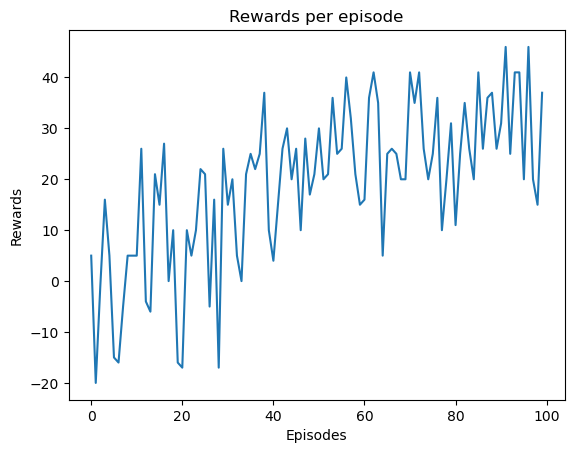

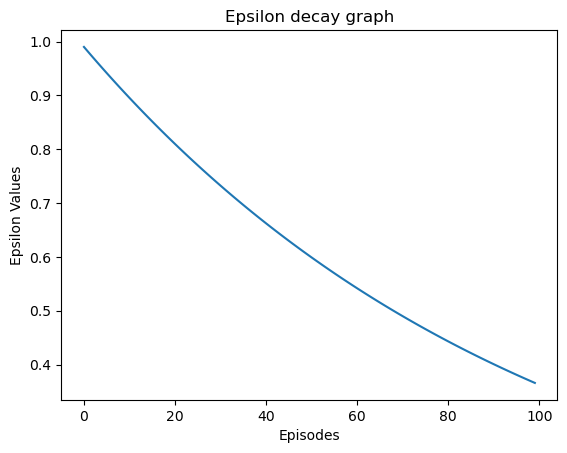

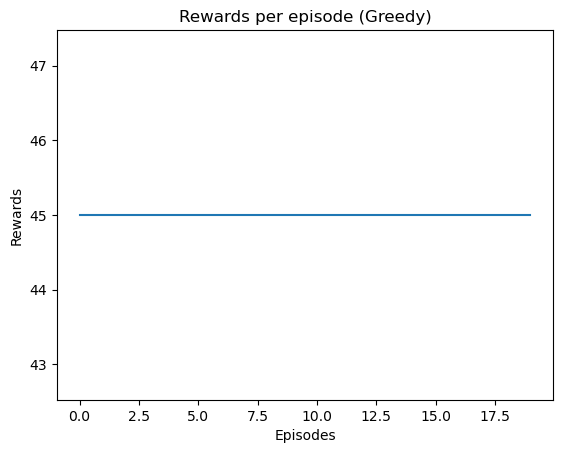

In [49]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 2

In [50]:
max_timesteps = 20
episodes = 200
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, reward_values, epsilon_values = Double_Q_Learning_Agent(env, 
                                                                                                          episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

In [51]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 8.77566125e+00  3.50206780e+00  2.72236089e+00  6.62294120e-01]
 [ 3.13265522e-01  2.89342926e-01  1.97386196e+00 -3.05462819e+00]
 [ 8.75520000e-03  0.00000000e+00  2.73196953e-01  0.00000000e+00]
 [-1.14000000e+00  0.00000000e+00 -4.99804041e-01  0.00000000e+00]
 [ 1.10715614e+01  3.21488816e+00  4.88643629e+00  2.32490743e+00]
 [ 5.31656185e-01  2.97304118e-01  5.91983635e+00  5.00859406e-02]
 [ 1.98086400e-01 -9.37259537e-01  4.44604185e-02 -6.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  3.10775731e-02  9.60000000e-03]
 [ 1.38788127e+01  7.84210347e+00  1.06868942e+01  4.95712706e+00]
 [ 4.52196858e-01  1.67365671e+00  1.00156385e+01  2.06355148e-01]
 [ 8.26517539e+00  0.00000000e+00  1.46874791

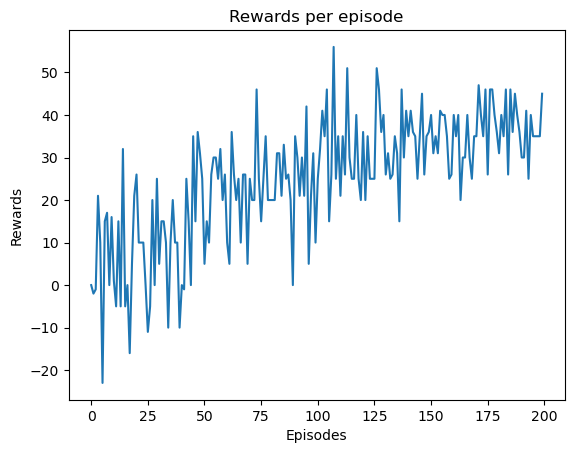

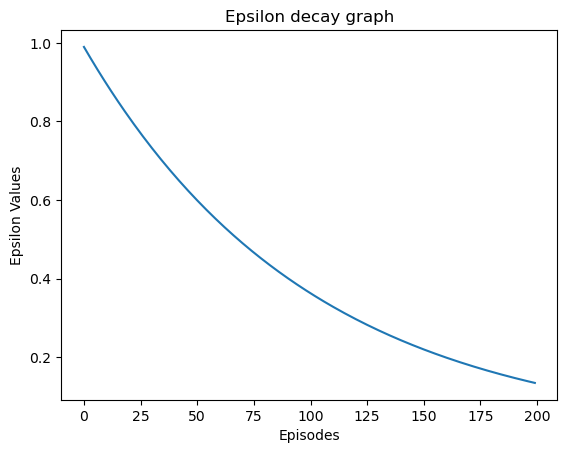

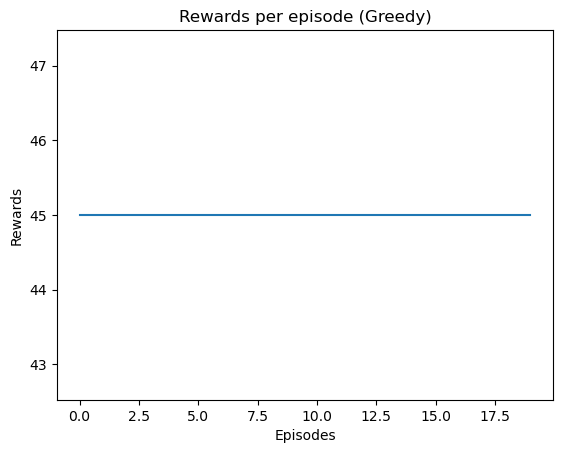

In [52]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 3

In [53]:
max_timesteps = 20
episodes = 300
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, reward_values, epsilon_values = Double_Q_Learning_Agent(env, 
                                                                                                                                episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

In [54]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 8.88762677e+00  2.46740050e+00  4.34790043e+00  2.42454852e-01]
 [ 2.96720118e-01  2.96748148e-02  3.52625019e+00 -2.84370261e+00]
 [ 0.00000000e+00  1.83316128e-03  3.34950437e-02 -7.48329381e-02]
 [-5.91360000e-01 -3.27478177e-02 -9.49221078e-01 -7.48132472e-02]
 [ 1.02323978e+01  3.32047600e+00  5.36770814e+00  1.44713274e+00]
 [ 4.06734699e+00  3.04519809e-03  3.98059396e-01  1.30535692e-01]
 [ 6.73240954e-01 -9.48755841e-01  5.99347445e-02 -1.61640000e+00]
 [ 2.28000000e-01  0.00000000e+00  5.34067200e-02  0.00000000e+00]
 [ 1.38888853e+01  8.05659366e+00  1.05851571e+01  8.04020685e+00]
 [ 3.29878917e+00  5.24875383e-01  1.07386761e+01  1.30895333e+00]
 [ 9.34710197e+00  7.12016640e-02  6.28377121

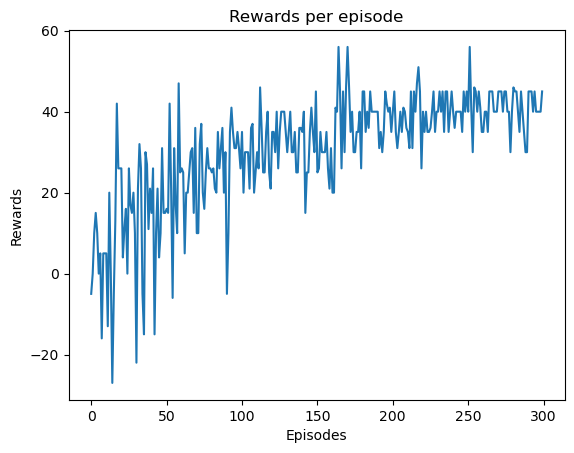

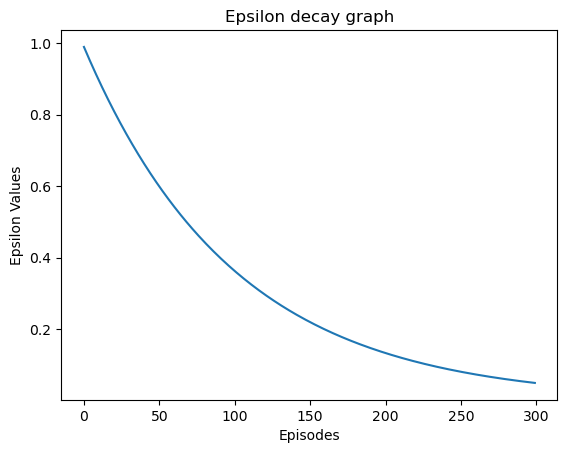

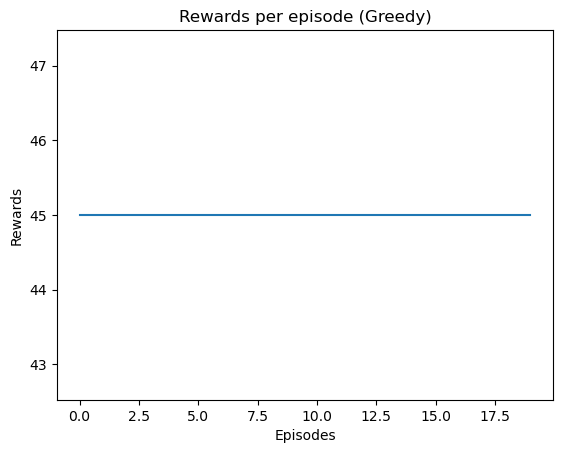

In [55]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

### Hyperparamters Tuning (Epsilon Decay)

#### Setup 1 

In [56]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.86

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, reward_values, epsilon_values = Double_Q_Learning_Agent(env,episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

In [57]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 8.88888887e+00  7.16426509e-01  1.34987880e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.11111111e+01  0.00000000e+00  2.38782078e+00  0.00000000e+00]
 [ 8.67200000e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.12000000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.38888889e+01  0.00000000e+00  1.28956658e+00  2.52820594e-01]
 [ 4.76874940e+00  8.83496960e-04  1.38046400e-01  0.00000000e+00]
 [ 2.07380640e+00  7.29600000e-03  0.00000000

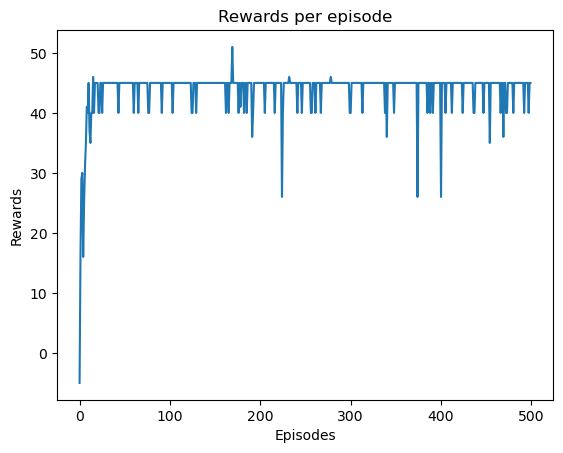

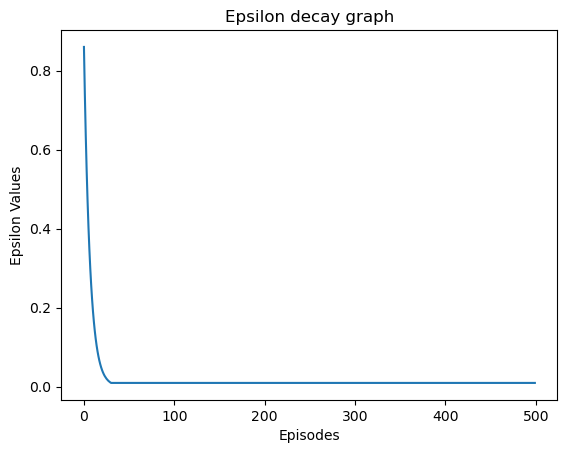

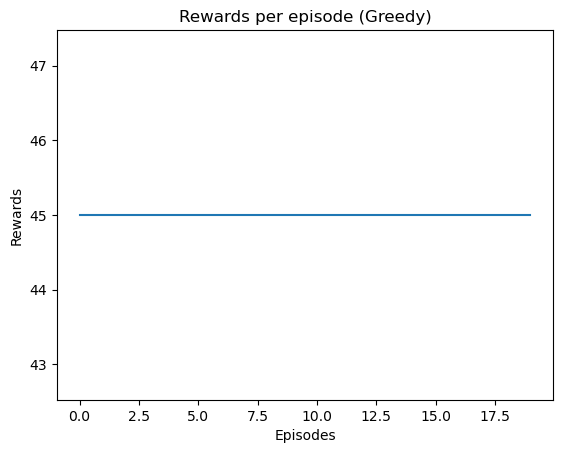

In [58]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 2

In [59]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.94

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, reward_values, epsilon_values = Double_Q_Learning_Agent(env,                                                                                                                             episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

In [60]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 8.88888889e+00  7.11110928e-01  4.68910733e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.50000000e-01]
 [ 5.32992000e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.11111111e+01  1.34839569e+00  0.00000000e+00  6.93760000e-04]
 [ 5.05259332e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.00000000e-01]
 [ 4.33200000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.38888889e+01  5.53261780e+00  5.46402493e+00  2.54460789e+00]
 [ 1.31188992e-01  0.00000000e+00  6.96210838e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000

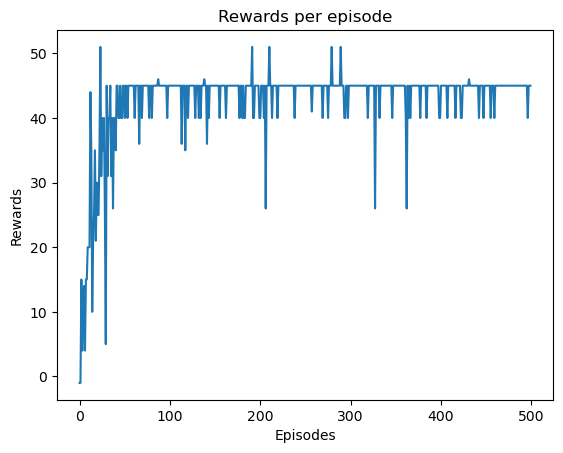

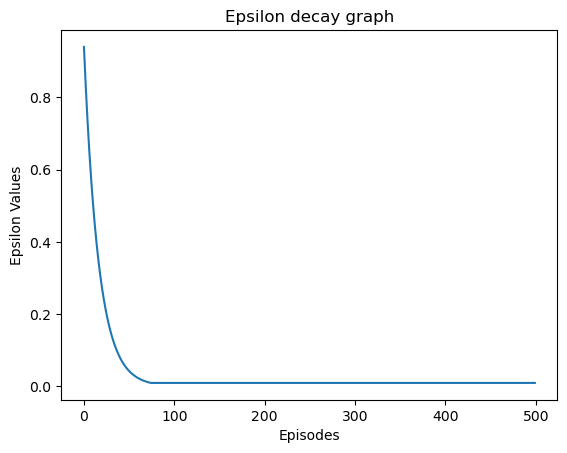

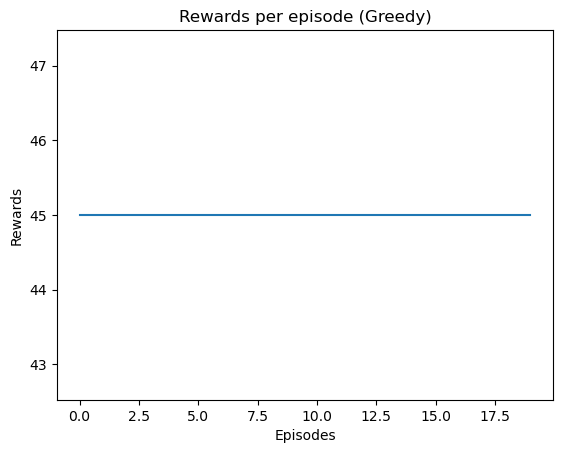

In [61]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

#### Setup 3

In [62]:
max_timesteps = 20
episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)

initial_q1_table, initial_q2_table, trained_q1_table, trained_q2_table, reward_values, epsilon_values = Double_Q_Learning_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor,epsilon_decay=epsilon_decay)

In [63]:
def select_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Double_Q_Learning_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrices
    Q1 = trained_q1_table
    Q2 = trained_q2_table

    dq_greedy_reward_values = []

    for episode in range(1, total_episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()

        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        
        while not terminated:
            Q_combined = Q1 + Q2
            curr_action = select_greedy_action_from_Q(Q_combined, curr_agent_state)

            next_agent_pos, obs, reward, terminated = env.step(curr_action)

            all_states = np.reshape(obs, (4, 4))
            next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)

            curr_agent_state = next_agent_state
            total_reward_per_episode += reward

        dq_greedy_reward_values.append(total_reward_per_episode)

    return dq_greedy_reward_values

max_timesteps = 20
dq_greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)

dq_greedy_reward_values = Trained_Double_Q_Learning_Agent(env, episodes=dq_greedy_episodes)

Initial Q1-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q1-table - 

[[ 1.05727845e+01  3.20839602e+00  2.59190685e+00  6.36725016e-01]
 [ 3.23021863e-01  6.00329467e-02  2.66133813e+00 -3.22727119e+00]
 [ 1.75860708e-01  0.00000000e+00  7.98474240e-05 -1.17576860e-01]
 [-6.00000000e-01 -3.45600000e-03 -4.95633072e-01 -3.84000000e-03]
 [ 1.32159966e+01  2.95341197e+00  5.11933965e+00  1.71059935e+00]
 [ 5.98941652e+00  1.41687368e-01  9.24583736e-01  4.38681377e-01]
 [ 2.84077434e+00 -4.93234481e-01  7.12469452e-03 -1.14000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.36847845e-01  0.00000000e+00]
 [ 1.65199989e+01  5.29519436e+00  6.84694116e+00  2.50018531e+00]
 [ 1.35125980e+01  1.34281802e+00  1.97904340e+00  1.81352857e+00]
 [ 1.25804480e+01  1.38624000e-02  3.67830246

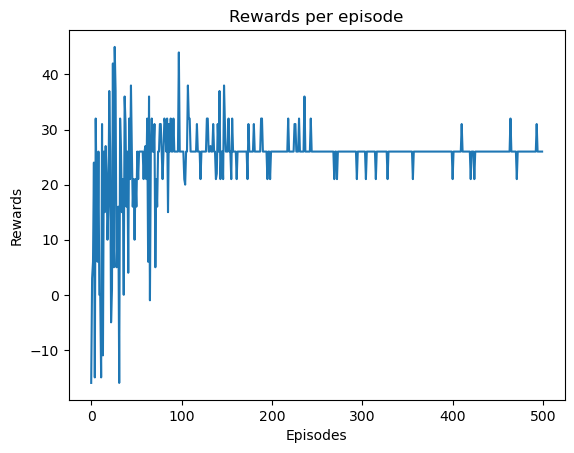

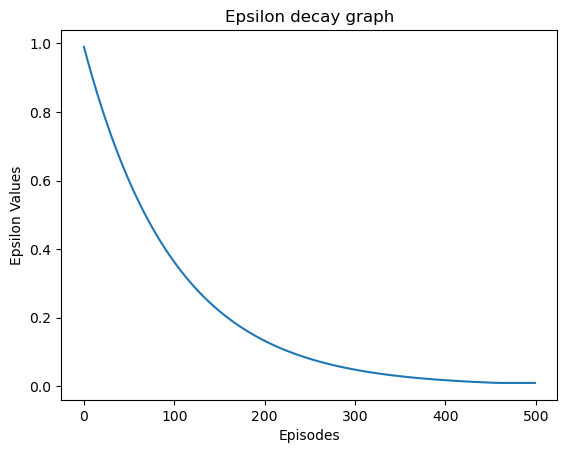

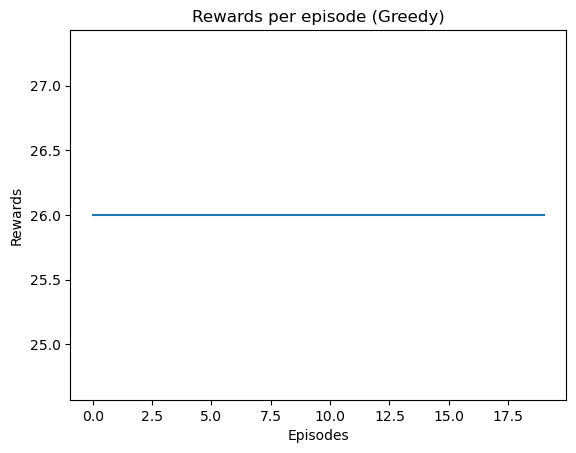

In [64]:
print_evaluation_metrics(
    initial_q1_table, 
    trained_q1_table, 
    initial_q2_table, 
    trained_q2_table, 
    episodes, reward_values, 
    epsilon_values, 
    dq_greedy_episodes, dq_greedy_reward_values,
    print_init_q1_table = True,
    print_init_q2_table = True,
    print_trained_q1_table = True,
    print_trained_q2_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward = True
)

In [65]:
def print_two_reward_dynamics(episodes,dq_reward_values,sarsa_reward_values):
    episodes_list = [episode for episode in range(episodes)]
    plt.figure()
    plt.plot(episodes_list, sarsa_reward_values, label='Sarsa Reward Values')
    plt.plot(episodes_list, dq_reward_values, label='DQ Reward Values')
    plt.title("Rewards per episode for Sarsa vs DQ-learning Algorithm")
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()

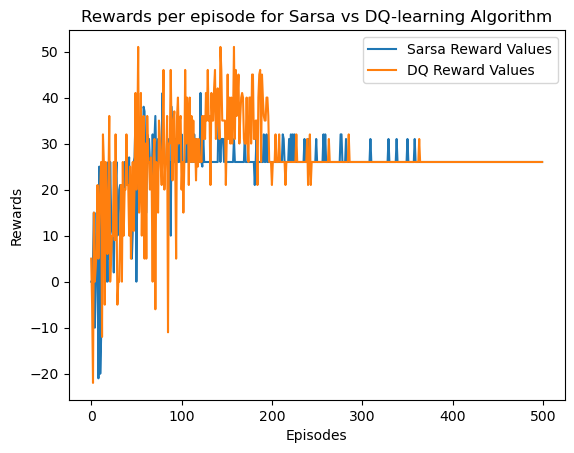

In [66]:
print_two_reward_dynamics(500, dq_reward_values, sarsa_reward_values)

#### BONUS TASK - n-step SARSA Algorithm

In [67]:
def get_state_index_in_flatten_array(curr_state, state):
    row_index = curr_state[0]
    col_index = curr_state[1]
    max_cols = state.shape[1]
    return row_index * max_cols + col_index

In [68]:
def select_action_from_Q(Q, state, epsilon):
    action = 0
    if epsilon > np.random.uniform(0, 1):
        total_actions = Q.shape[1]
        action = np.random.randint(total_actions)
    else:
        action = np.argmax(Q[state])
    
    return action

In [94]:
def two_step_SARSA_Agent(env, episodes, epsilon, learning_rate, discount_factor, epsilon_decay, reward):
    #total_episodes = episodes
    total_actions = env.action_space.n
    total_states = env.observation_space.n

    # Initializing our Q matrix
    Q = np.zeros((total_states, total_actions))
    two_step_sarsa_greedy_reward_values = []
    initial_q_table = copy.deepcopy(Q)
    optimal = []
    reward_values = []
    epsilon_values = []

    for episode in range(1, episodes + 1):
        total_reward_per_episode = reward
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_action_from_Q(Q, curr_agent_state, epsilon)
        t = 0
        n=2
        t1 = 0
        T = float('inf')
        if epsilon > 0.01:
            epsilon = epsilon * epsilon_decay
        states = [curr_agent_state]
        actions = [curr_action]
        rewards = [reward]
        n=2
        while not terminated:
                if t < T:
                    next_agent_pos, obs, reward, terminated = env.step(curr_action)
                    all_states = np.reshape(obs, (4, 4))
                    next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
                    next_action = select_action_from_Q(Q, next_agent_state, epsilon)
                    Q[curr_agent_state][curr_action] = Q[curr_agent_state][curr_action] + learning_rate * (reward + discount_factor * Q[next_agent_state][next_action] - Q[curr_agent_state][curr_action])
                    if episode == episodes:
                        optimal.append(curr_agent_state + 1)
                
                    curr_agent_state = next_agent_state
                    curr_action = next_action
                    total_reward_per_episode += reward
                    print(f"Episode:{episode}  Epsilon:{epsilon:4f}  Reward:{total_reward_per_episode}")
                    #reward_values.append(total_reward_per_episode)
                    
                    states.append(next_agent_state)
                    actions.append(next_action)
                    rewards.append(reward)
                    
                if terminated:
                    T = t + 1
                    
        t1 = t - n + 1
        if t1 >= 0:
            G = sum([discount_factor**(i - t1 - 1) * rewards[i] for i in range(t1 + 1, min(t1 + n, T))])
            if t1 + n < T:
                G += discount_factor**n * Q[states[t1 + n]][actions[t1 + n]]
            Q[states[t1]][actions[t1]] += learning_rate * (G - Q[states[t1]][actions[t1]])


        reward_values.append(total_reward_per_episode)
        two_step_sarsa_greedy_reward_values.append(total_reward_per_episode)
        epsilon_values.append(epsilon)

    return initial_q_table, Q, reward_values, epsilon_values

In [125]:
max_timesteps = 20

episodes = 500
epsilon = 1
learning_rate = 0.1
discount_factor = 0.8
epsilon_decay = 0.99

env = LawnmowerGridWorldEnvironment(max_timesteps)
initial_two_step_q_table, trained_two_step_q_table, two_step_reward_values, epsilon_values = two_step_SARSA_Agent(env, episodes=episodes, epsilon=epsilon, learning_rate=learning_rate, discount_factor=discount_factor, epsilon_decay=epsilon_decay, reward=reward_values[-1])

Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:41
Episode:1  Epsilon:0.990000  Reward:47
Episode:1  Epsilon:0.990000  Reward:62
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:15
Episode:2  Epsilon:0.980100  Reward:10
Episode:2  Epsilon:0.980100  Reward:10
Episode:2  Epsilon:0.9801

In [126]:
def select_only_greedy_action_from_Q(Q, state):
    return np.argmax(Q[state])

def Trained_Two_Step_SARSA_Agent(env, episodes):
    total_episodes = episodes

    # Using trained Q matrix
    Q =  trained_two_step_q_table
    reward_values = []
    two_step_sarsa_greedy_reward_values=[]

    for episode in range(1, episodes + 1):
        total_reward_per_episode = 0
        terminated = False
        agent_pos, observation = env.reset()
        all_states = np.reshape(observation, (4, 4))
        curr_agent_state = get_state_index_in_flatten_array(agent_pos, all_states)
        curr_action = select_only_greedy_action_from_Q(Q, curr_agent_state)
        t = 0
        n=2
        t1 = 0
        T = float('inf')
        states = [curr_agent_state]
        actions = [curr_action]
        n=2
        while not terminated:
                if t < T:
                    next_agent_pos, obs, reward, terminated = env.step(curr_action)
                    all_states = np.reshape(obs, (4, 4))
                    next_agent_state = get_state_index_in_flatten_array(next_agent_pos, all_states)
                    next_action = select_only_greedy_action_from_Q(Q, next_agent_state)
                    curr_agent_state = next_agent_state
                    curr_action = next_action
                    total_reward_per_episode += reward
                    
                    states.append(next_agent_state)
                    actions.append(next_action)
                    
                if terminated:
                    T = t + 1
                    
        t1 = t - n + 1
        if t1 >= 0:
            G = sum([discount_factor**(i - t1 - 1) * rewards[i] for i in range(t1 + 1, min(t1 + n, T))])
            if t1 + n < T:
                G += discount_factor**n * Q[states[t1 + n]][actions[t1 + n]]
            Q[states[t1]][actions[t1]] += learning_rate * (G - Q[states[t1]][actions[t1]])


        reward_values.append(total_reward_per_episode)
        two_step_sarsa_greedy_reward_values.append(total_reward_per_episode)

    return two_step_sarsa_greedy_reward_values


max_timesteps = 20
greedy_episodes = 20

env = LawnmowerGridWorldEnvironment(max_timesteps)
two_step_sarsa_greedy_reward_values = Trained_Two_Step_SARSA_Agent(env, episodes=greedy_episodes)

In [127]:
def print_evaluation_metrics(
        initial_q_table, 
        trained_q_table, 
        episodes, reward_values, 
        epsilon_values, 
        two_step_sarsa_greedy_episodes, two_step_sarsa_greedy_reward_values,
        print_init_q_table = False,
        print_trained_q_table = False,
        plot_rewards_per_episode = False, 
        plot_epsilon_decay = False,
        plot_greedy_action_reward = False
):
    
    episodes_list = [episode for episode in range(episodes)]
    two_step_sarsa_greedy_episodes_list = [greedy_episode for greedy_episode in range(two_step_sarsa_greedy_episodes)]
    if(print_init_q_table):
        print("Initial Q-table - \n")
        print(f"{initial_q_table} \n")
    
    if(print_trained_q_table):
        print("Trained Q-table - \n")
        print(f"{trained_q_table}")
    
    if(plot_rewards_per_episode):
        plt.figure()    
        plt.plot(episodes_list, reward_values)
        plt.title("Rewards per episode")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')

    if(plot_epsilon_decay):    
        plt.figure()
        plt.plot(episodes_list, epsilon_values)
        plt.title("Epsilon decay graph")
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon Values')

    if(plot_greedy_action_reward):
        plt.figure()    
        plt.plot(two_step_sarsa_greedy_episodes_list, two_step_sarsa_greedy_reward_values)
        plt.title("Rewards per episode (Greedy)")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        


Initial Q-table - 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 

Trained Q-table - 

[[ 1.03933425e+01  4.31386941e+00  3.76527438e+00  1.18251075e+00]
 [ 3.78526962e+00  4.07754197e-02  2.22620164e-01 -3.06420055e+00]
 [-4.31652993e-02 -2.07113050e-02 -7.80051679e-02 -1.79753920e-01]
 [-1.10640000e+00 -3.20000000e-03 -2.05155343e+00 -1.44400000e-01]
 [ 1.29655651e+01  3.30327753e+00  6.75065476e+00  3.22025237e+00]
 [ 1.09389616e+00 -9.04545519e-02  8.46724422e+00  2.41194039e-01]
 [ 2.19664118e+00 -1.35573309e+00  6.28031352e-02 -2.45706000e+00]
 [ 1.17144372e+00 -7.60000000e-02  0.00000000e+00  0.00000000e+00]
 [ 1.62786640e+01  5.42246001e+00  8.95000013e+00  4.60438593e+00]
 [ 1.33642166e+00  2.59363402e-01  1.06409782e+01  2.27207039e+00]
 [ 1.50559126e+01 -8.28878088e-02  4.49453226e-

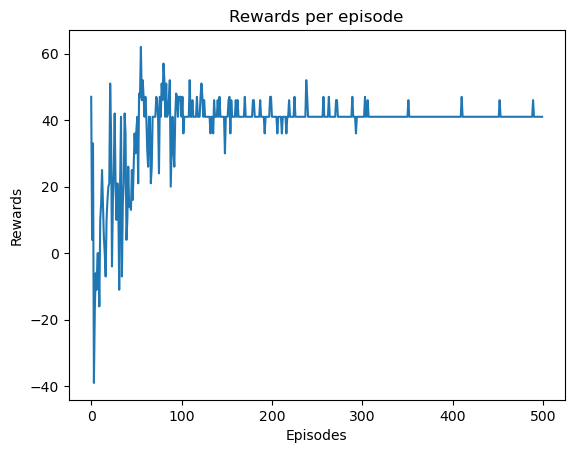

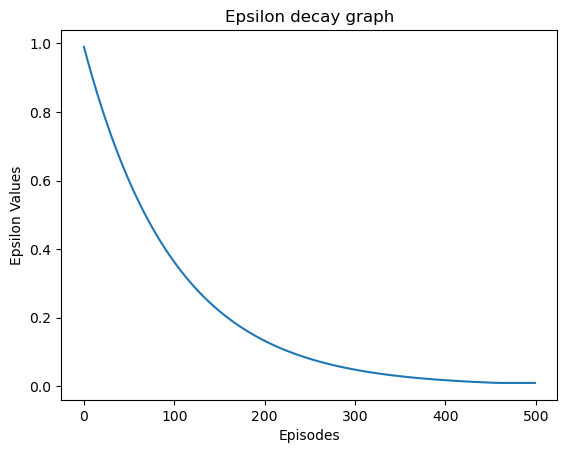

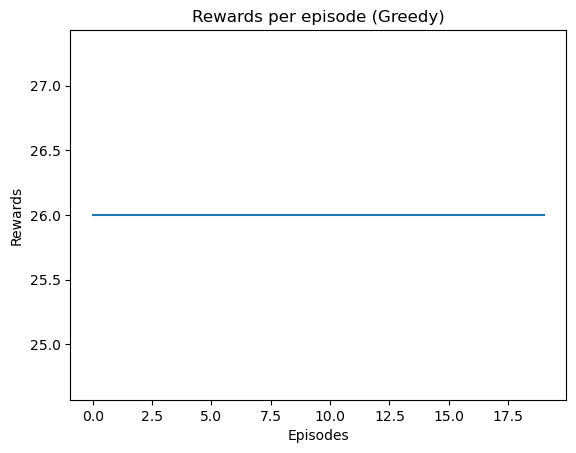

In [124]:
two_step_sarsa_greedy_episodes=20
print_evaluation_metrics(
    initial_q_table, 
    trained_q_table, 
    episodes, reward_values, 
    epsilon_values, 
    two_step_sarsa_greedy_episodes, 
    two_step_sarsa_greedy_reward_values,
    print_init_q_table = True,
    print_trained_q_table = True,
    plot_rewards_per_episode = True, 
    plot_epsilon_decay = True,
    plot_greedy_action_reward=True)

In [132]:
def print_two_reward_dynamics(episodes,sarsa_reward_values,two_step_reward_values):
    episodes_list = [episode for episode in range(episodes)]
    plt.figure()
    plt.plot(episodes_list, sarsa_reward_values, label='Sarsa Reward Values')
    plt.plot(episodes_list, two_step_reward_values, label='Two Sarsa Reward Values')
    plt.title("Rewards per episode for Sarsa vs Two-Step-Sarsa-learning Algorithm")
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()

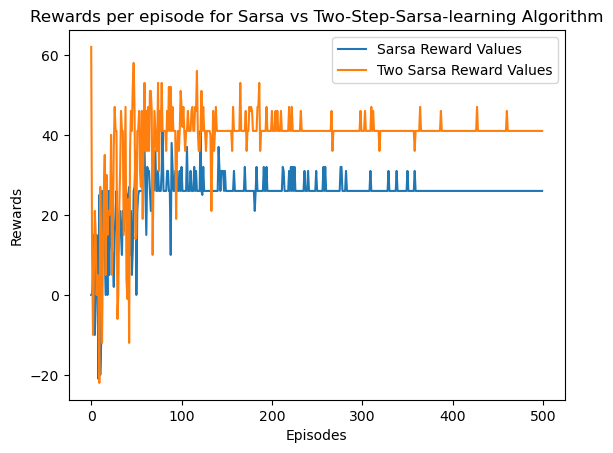

In [133]:
print_two_reward_dynamics(500, sarsa_reward_values, two_step_reward_values)

#### Bonus Task
#### Grid-World Scenario Visualization 

## Refernces


* Code taken from Wumpus World https://ubuffalo-my.sharepoint.com/:f:/g/personal/avereshc_buffalo_edu/Er0ESPRw4HFMjPpRokyJ7TYBPErfobIaPqritqkGpM1EOA?e=vgaaek
* https://optuna.org
* https://colab.research.google.com/drive/1rDsBx-FwG2NUEs_PocAioOHje5uVFNgQ and https://colab.research.google.com/drive/1YiV2RsOzbiF12zjj6C0lnx3dqufGBBKj
* https://builtin.com/machine-learning/sarsa
* https://towardsdatascience.com/introduction-to-reinforcement-learning-rl-part-7-n-step-bootstrapping-6c3006a13265
* https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187
* https://towardsdatascience.com/introduction-to-reinforcement-learning-rl-part-7-n-step-bootstrapping-6c3006a13265
* http://incompleteideas.net/book/the-book-2nd.html
* Reference of the algorithm taken from CSE 574 Machine Learning by Alina Vereshchaka
* https://www.kaggle.com/code/nagakiranreddy/reinforcement-learning-sarsa-on-grid-world-env